# Artificial Intelligence in Medicine: A 500 ft Technical Overview 

In [2]:
print('Hello world')

Hello world


# Computer Vision: Image classification

#### Imports

In [1]:
!pip install fastcore
!pip install fastprogress
!pip install fastai
!pip install torcheval
#!pip install --upgrade huggingface_hub

import sys 
import os
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
parent_dir
sys.path.append(parent_dir)

import torch,random
import fastcore.all as fc
from torch import nn
from torch.nn import init
from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.training import *
from miniai.datasets import DataLoaders as miniai_DataLoaders
#import huggingface_hub
#print(huggingface_hub.__version__)
import pickle,gzip,math,os,time,shutil
import matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,optim
from torch.utils.data import DataLoader,default_collate
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy, BinaryAccuracy, Mean
from datasets import load_dataset,load_dataset_builder
from fastcore.test import test_close
from torch import distributions
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray_r'
import logging
logging.disable(logging.WARNING)
from fastai.data.external import untar_data
from fastai.vision.all import *    #URLs, TensorImage, ImageDataLoaders
from IPython.display import Image as IMG
import pandas as pd

set_seed(42)

if fc.defaults.cpus>8: fc.defaults.cpus=8
print('Done with imports')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.8/234.8 kB 4.9 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.2/84.2 kB 14.7 MB/s eta 0:00:00
  Attempting uninstall: fastcore
    Found existing installation: fastcore 1.8.0
    Uninstalling fastcore-1.8.0:
      Successfully uninstalled fastcore-1.8.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 2.5 MB/s eta 0:00:00ta 0:00:01
Done with imports


## Simple Neural Network

#### Here's our basic training loop:

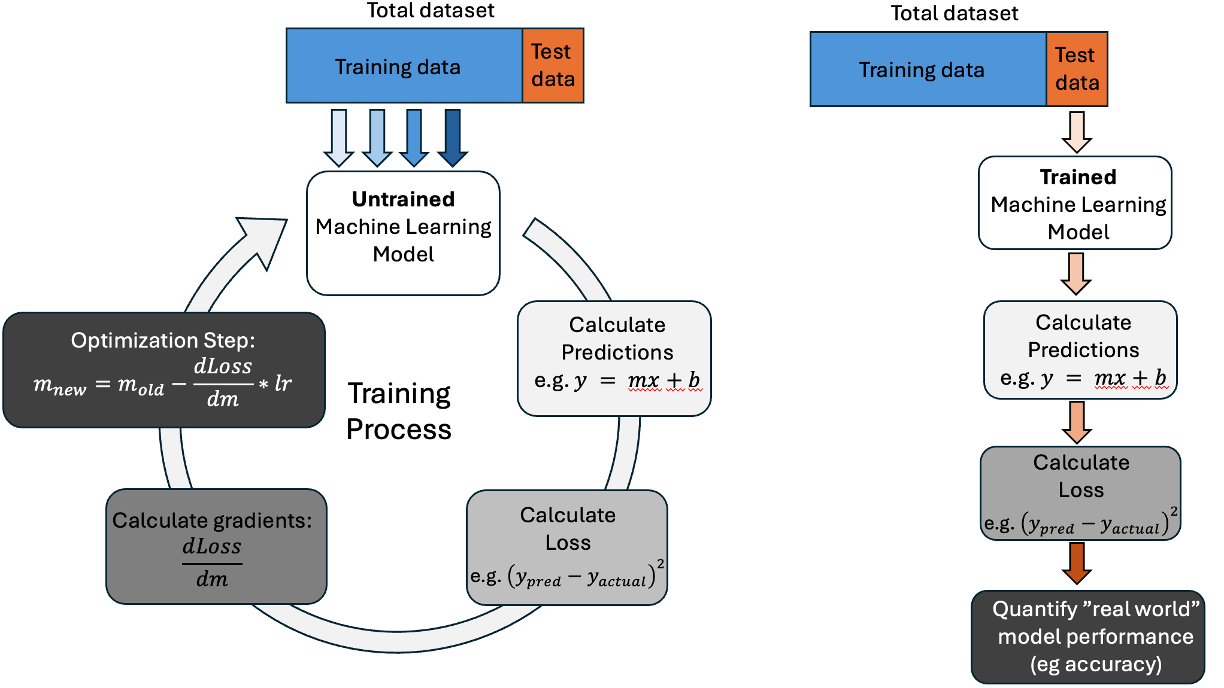

In [4]:
IMG("../AI_USU/Images/NN_TngLoop_New.png")

#### Basic Neural Network Terminology:

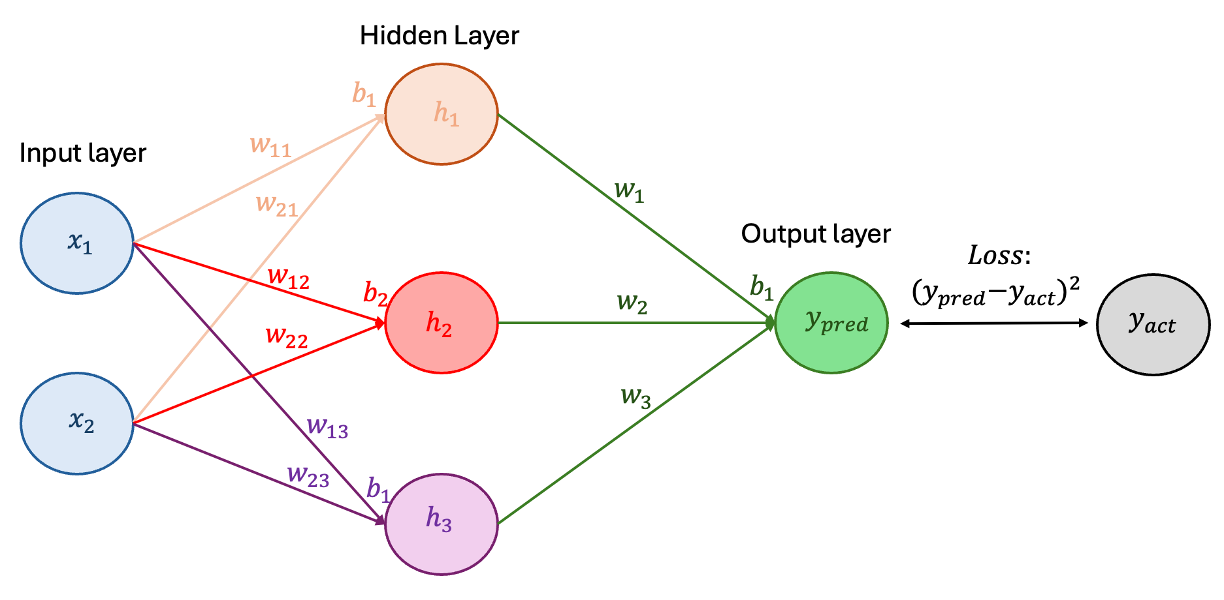

In [31]:
IMG("../AI_USU/Images/SimpleNN.png")

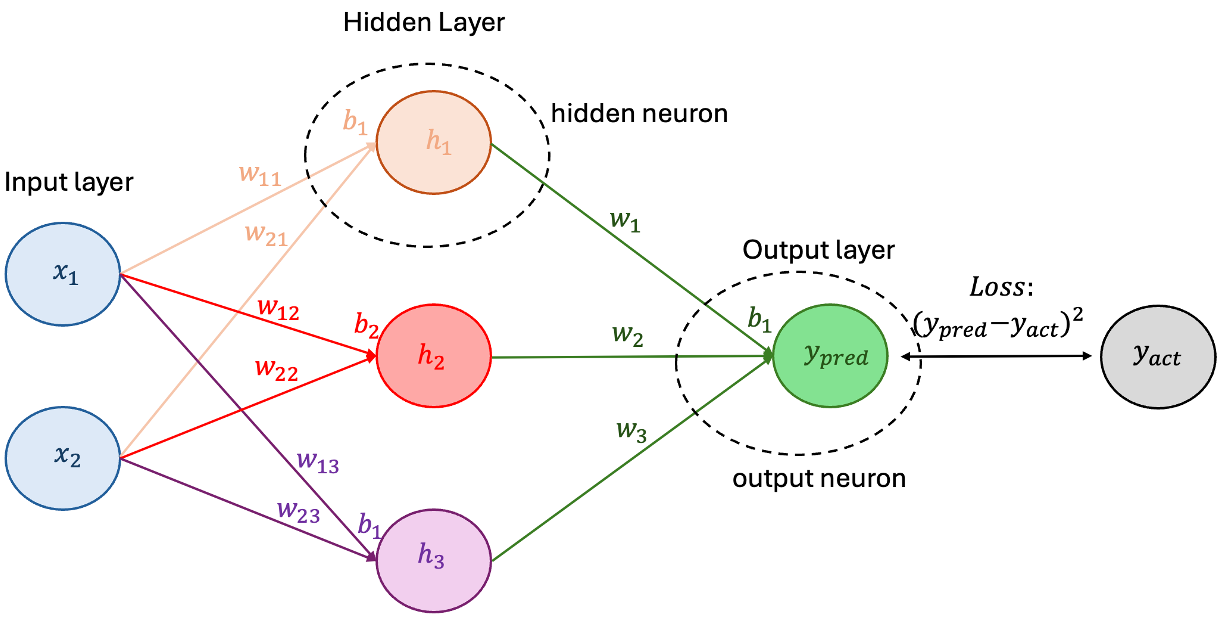

In [32]:
IMG("../AI_USU/Images/SimpleNN_NeuronOutline.png")

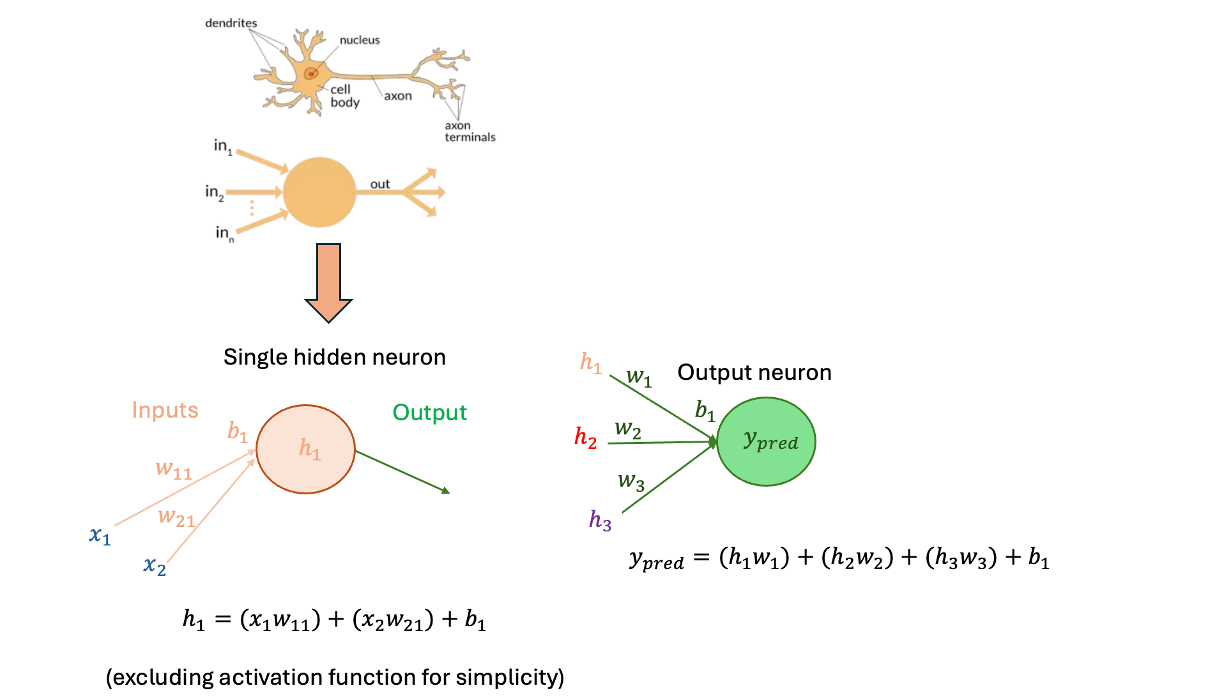

In [2]:
IMG("../AI_USU/Images/NN_Neurons.png")

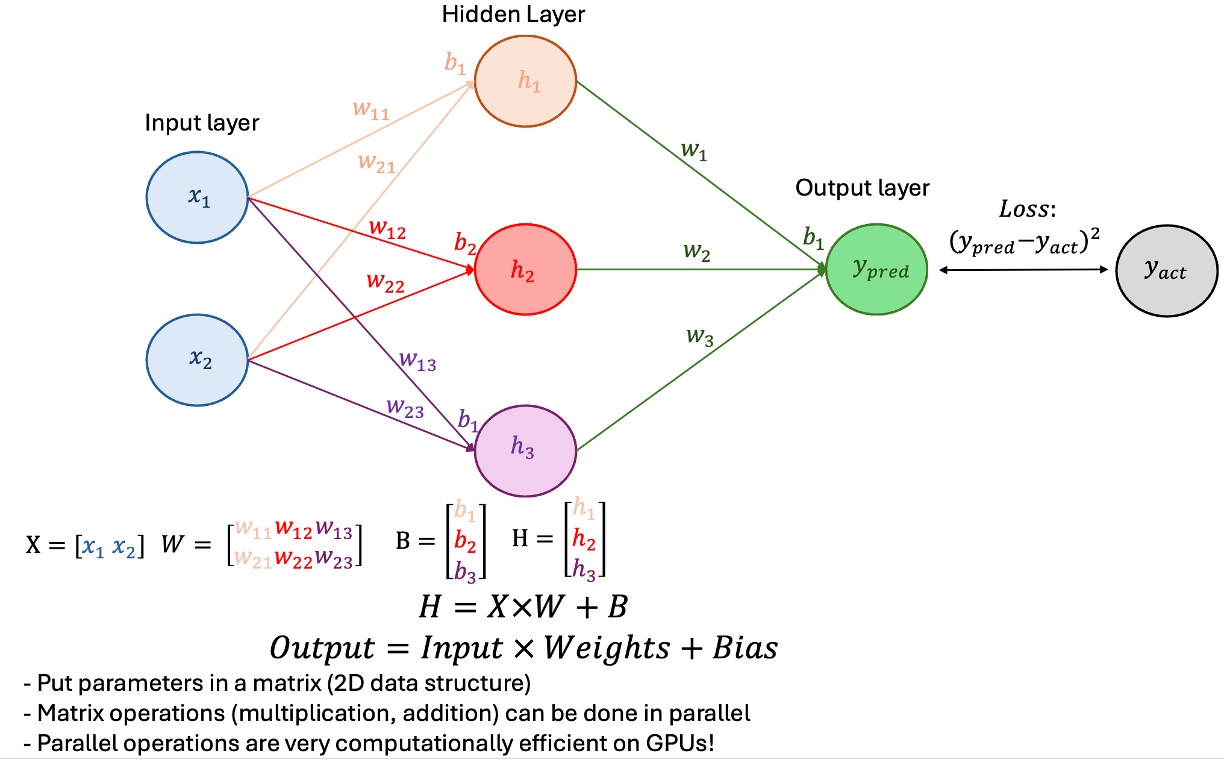

In [7]:
IMG("../AI_USU/Images/NN_math.png")

### Let's try an example: MNIST Dataset

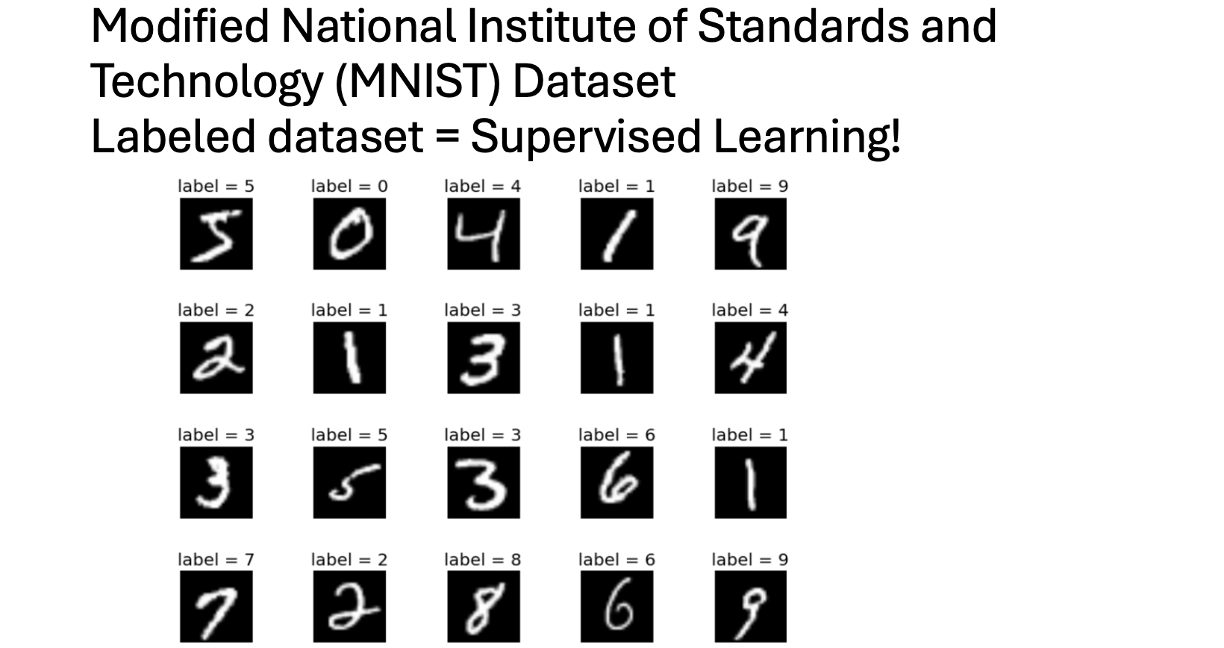

In [69]:
IMG("../AI_USU/Images/MNIST.png")

- Fun Fact: National Institute of Standards and Technology is located in Gaithersburg, Maryland. Practically in our backyard!
- Let's use a subset of this dataset, using images that are only a 3 or a 7. The total dataset size is about 70,000 images, our subset is only about 10,000.

/root/.fastai/data/mnist_sample


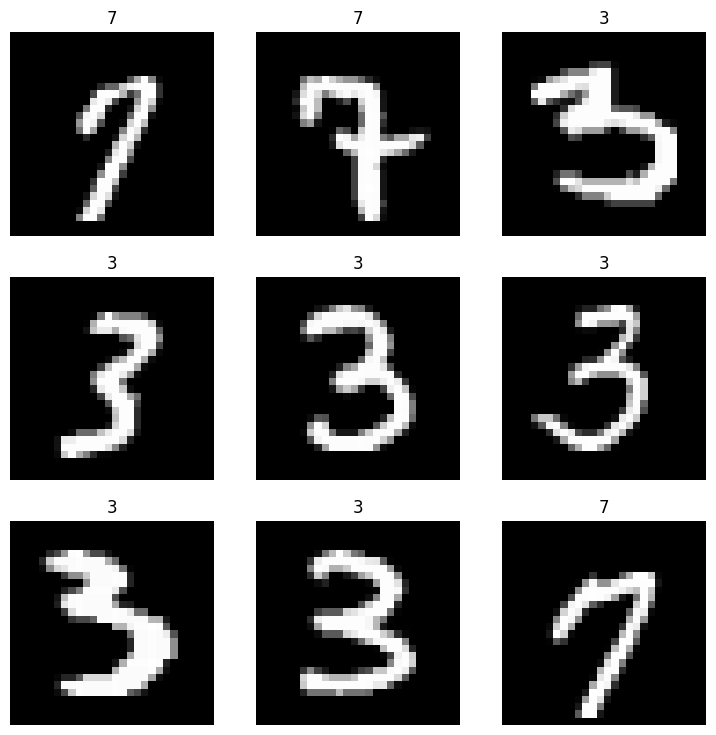

In [2]:
path = untar_data(URLs.MNIST_SAMPLE)
print(path)
dls_ex = ImageDataLoaders.from_folder(path, valid_pct=0.2, seed=42, bs=512)
dls_ex.show_batch()

In [3]:
mnist_block = DataBlock(
    blocks=(ImageBlock(PILImageBW), CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(28),
    batch_tfms=[IntToFloatTensor, lambda x: x.view(x.size(0), -1)] 
)

dls_sample = mnist_block.dataloaders(path, bs=512)

In [4]:
path_3 = path/'train'/'7'

image_files = [f.name for f in path_3.glob('*.png')]

from PIL import Image

im3 = Image.open(path/'train'/'3'/'12.png')
im3_t = TensorImage(im3)
im7 = Image.open(path/'train'/'7'/'33651.png')
im7_t = TensorImage(im7)

df = pd.DataFrame(im3_t[:,:])
pd.set_option('display.max_columns', 28)
df.style.set_properties(**{'font-size':'9pt'}).background_gradient('Greys')

#### Goal: predict whether the image is a 3 or a 7 using a simple neural network

#### STEP 2: Choose a model architecture
 - Neural network with 1 hidden layer: 3 layers total

In [6]:
xb_sample, yb_sample = dls_sample.one_batch()
m_sample = xb_sample.shape[1]
nh_sample = 10
m_sample, len(dls_sample.train.dataset)

(784, 11548)

In [7]:
yb_sample.as_subclass(torch.Tensor).squeeze().shape

torch.Size([512])

In [8]:
model_mnist_sample = nn.Sequential(
    nn.Linear(m_sample, nh_sample),
    nn.ReLU(),
    nn.Linear(nh_sample, 1),
    nn.Sigmoid(),
    nn.Flatten()).to(def_device)

preds = model_mnist_sample(xb_sample)
preds.shape, type(preds), type(preds.as_subclass(torch.Tensor))

(torch.Size([512, 1]), fastai.torch_core.TensorImageBW, torch.Tensor)

In [9]:
for name, param in model_mnist_sample.named_parameters():
    if param.requires_grad:
        print(f"Layer: {name} | Shape: {param.shape}")
        print(f'{param.data}, Mean: {param.data.mean().item():.3f}, Std: {param.data.std().item():.3f}')

Layer: 0.weight | Shape: torch.Size([10, 784])
tensor([[ 0.03, -0.03,  0.03,  ..., -0.03, -0.02, -0.03],
        [-0.02, -0.02,  0.02,  ..., -0.01,  0.01,  0.03],
        [-0.01,  0.00,  0.02,  ...,  0.00, -0.03, -0.02],
        ...,
        [-0.03,  0.03,  0.00,  ..., -0.01,  0.03, -0.02],
        [-0.01, -0.00, -0.02,  ...,  0.01, -0.03, -0.01],
        [ 0.02,  0.00,  0.03,  ..., -0.01,  0.00, -0.01]], device='cuda:0'), Mean: -0.000, Std: 0.021
Layer: 0.bias | Shape: torch.Size([10])
tensor([-0.03, -0.02, -0.01, -0.01, -0.02, -0.01, -0.03, -0.03,  0.02, -0.01], device='cuda:0'), Mean: -0.014, Std: 0.015
Layer: 2.weight | Shape: torch.Size([1, 10])
tensor([[    -0.10,      0.00,      0.05,     -0.21,      0.14,      0.14,      0.14,     -0.23,      0.28,      0.17]], device='cuda:0'), Mean: 0.039, Std: 0.171
Layer: 2.bias | Shape: torch.Size([1])
tensor([0.09], device='cuda:0'), Mean: 0.090, Std: nan


##### Pics

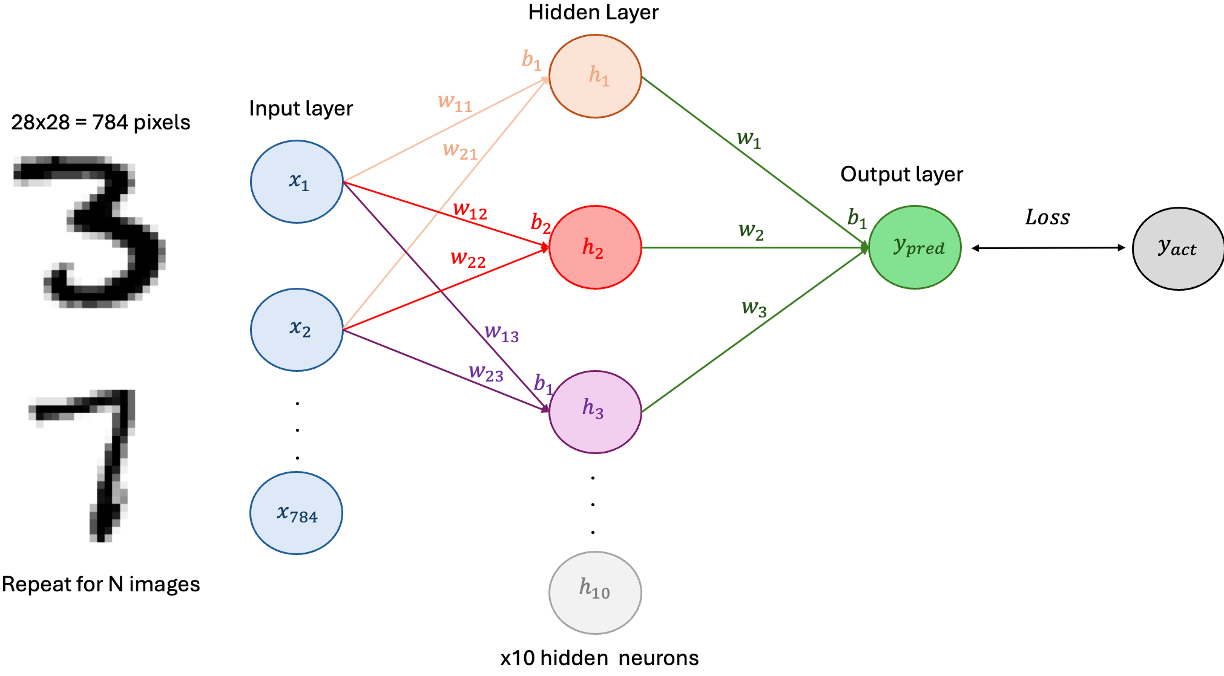

In [12]:
IMG("../AI_USU/Images/Simple_MNIST_NN.png")

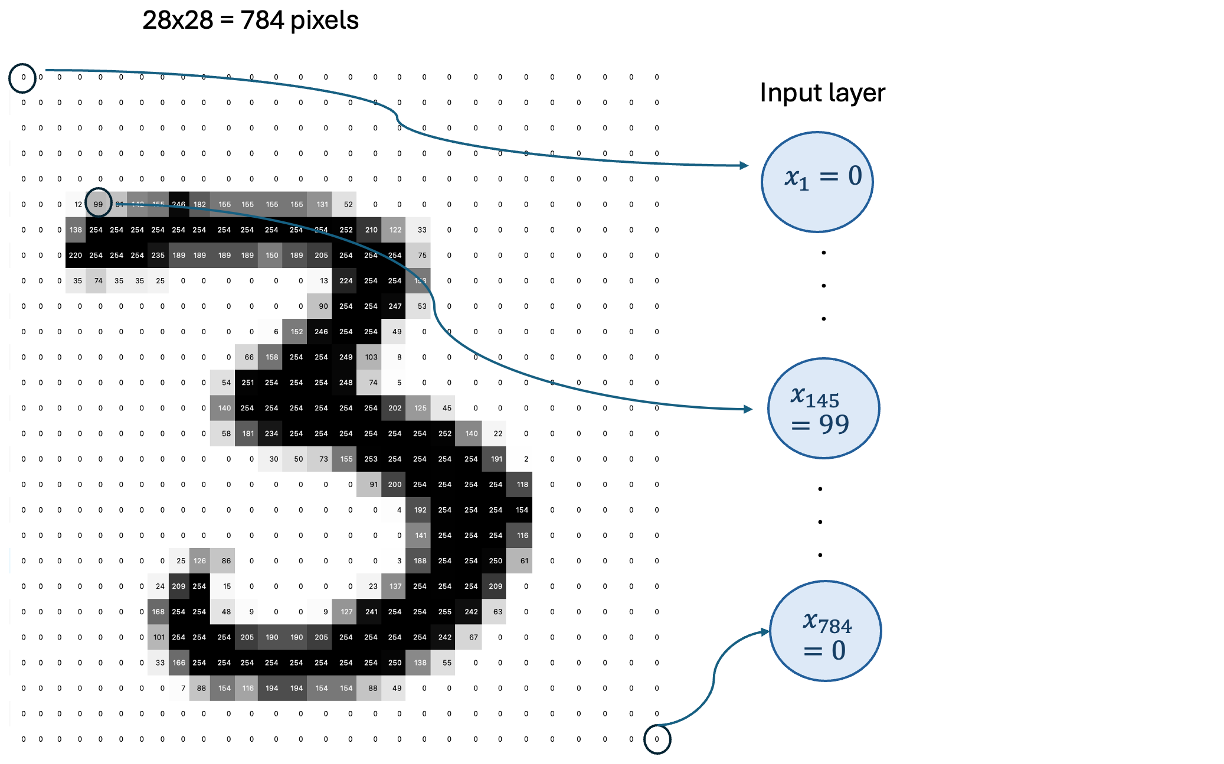

In [10]:
IMG("../AI_USU/Images/SimpleNN_3.png")

#### STEP 3: Randomly initialize our model parameters (w, b)
- mean:0, standard deviation: 1

Let's count our total # of parameters:
- Input layer -> hidden layer: 784*10 + 10
- Hidden layer -> output layer: 10*1 + 1
- Total # parameters: 7861

##### Pics

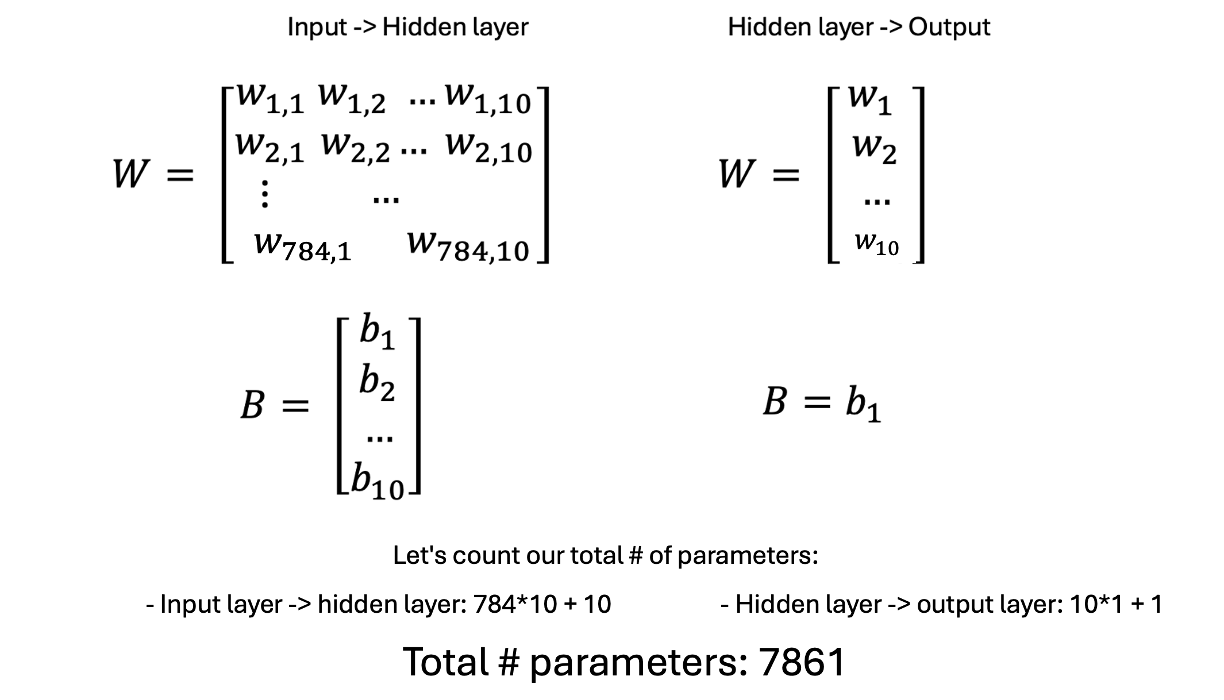

In [11]:
IMG("../AI_USU/Images/Matrix_new.png")

#### STEP 4: Pass in our data, calculate our loss

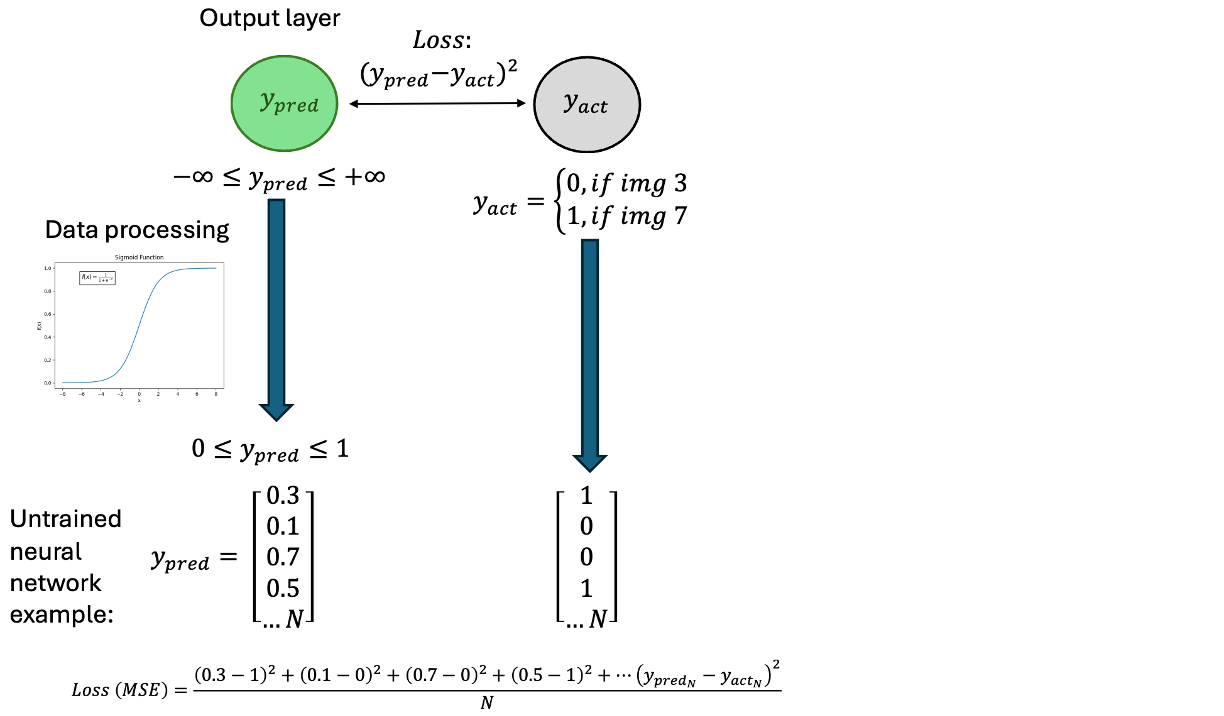

In [28]:
IMG("../AI_USU/Images/NN_Loss_New.png")

We just did a Forward pass through our neural network!

New let's do a backward pass "backward propagation of loss": Backpropagation is an optimization technique used to adjust the weights and biases of a neural network by minimizing the error between the network's predicted output and the actual target output. It works by propagating the error backward from the output layer to the input layer, layer by layer, updating the parameters to reduce the overall error.

#### STEP 5: Calculate our gradients

##### Pics

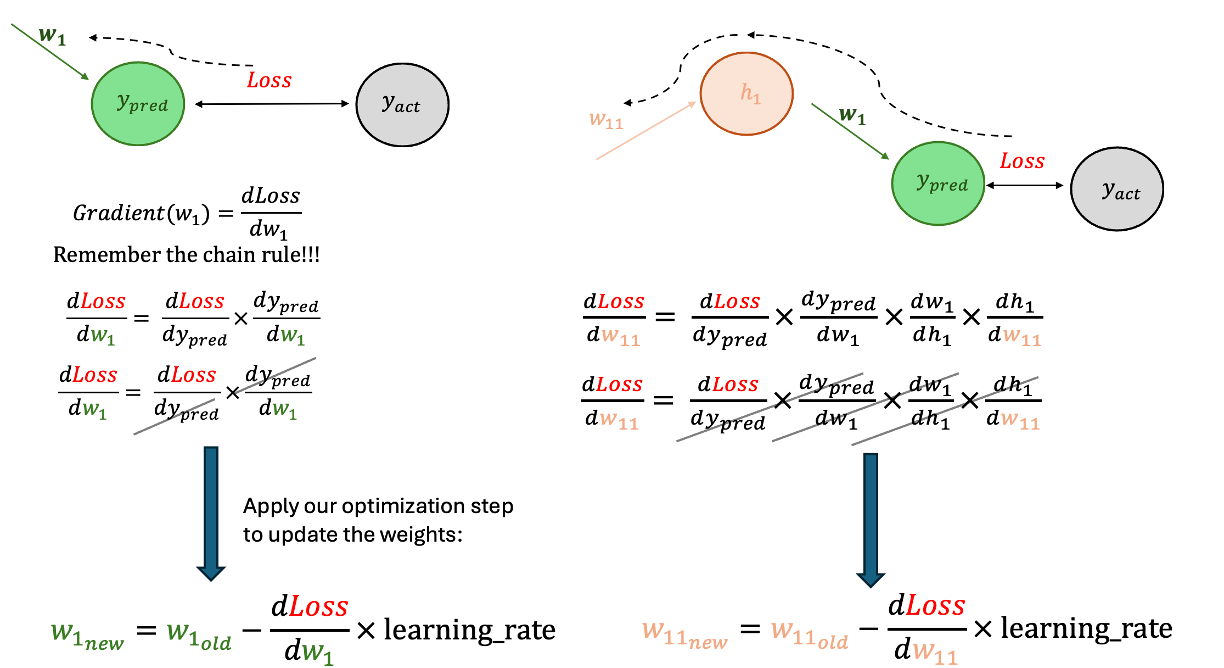

In [30]:
IMG("../AI_USU/Images/NN_grads.png")

#### STEP 6: optimizer, change the model parameters (W, B) in a way that reduces the loss

##### Pics

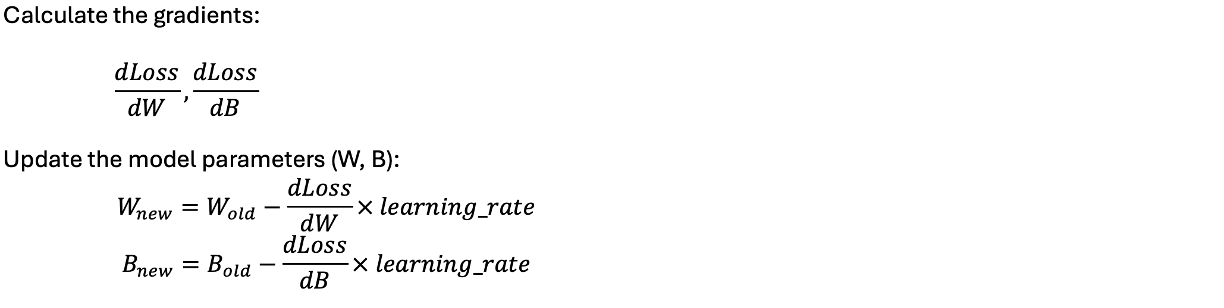

In [31]:
IMG("../AI_USU/Images/NN_grad_calc.png")

##### Code:

In [12]:
class MetricsCB_sample(Callback):
    def __init__(self, *ms, **metrics):
        for o in ms: metrics[type(o).__name__] = o
        self.metrics = metrics
        self.all_metrics = copy(metrics)
        self.all_metrics['loss'] = self.loss = Mean() # Creates an instance of the Mean() class

    def _log(self, d): print(d)
    def before_fit(self, learn): learn.metrics = self
    def before_epoch(self, learn): [o.reset() for o in self.all_metrics.values()]

    def after_epoch(self, learn):
        log = {k: f'{v.compute():.3f}' for k, v in self.all_metrics.items()}
        log['epoch'] = learn.epoch
        log['train'] = 'train' if learn.model.training else 'eval'
        self._log(log)

    def after_batch(self, learn):
        x, y, *_ = to_cpu(learn.batch)
        preds = learn.preds.as_subclass(torch.Tensor).float().view(-1)
        #preds = to_cpu(learn.preds)
        preds = to_cpu(preds)
        y = y.float().as_subclass(torch.Tensor).float().view(-1)
        
        # Print shapes for debugging
        #print(f'preds: {preds}, y: {y}')
        #print(f'After batch - preds shape: {preds.shape}, y shape: {y.shape}')

        # Ensure shapes are consistent
        if preds.shape != y.shape:
            y = y.view_as(preds)
            #preds = preds.view_as(y)

        for m in self.metrics.values():
            m.update(preds, y)
        self.loss.update(to_cpu(learn.loss), weight=len(x))


metrics = MetricsCB_sample(accuracy=BinaryAccuracy())
cbs_sample = [DeviceCB(), metrics, ProgressCB(plot=True)]  

def custom_bce_loss(input, target):
    input = input.as_subclass(torch.Tensor).float().view(-1)
    target = target.as_subclass(torch.Tensor).float().view(-1)
    input = input.to(def_device)
    target = target.to(def_device)
    return F.binary_cross_entropy(input, target.view_as(input))

#### Step 7: iterate through our training loop many times until the loss is driven to a minimum value

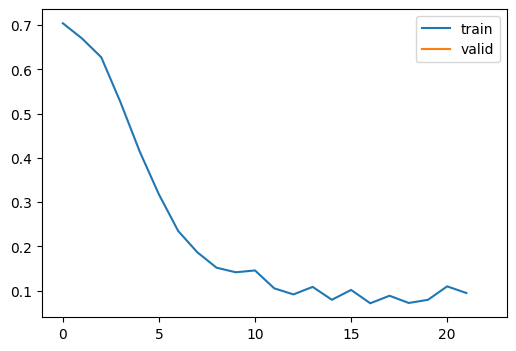

In [13]:
learn_sample = TrainLearner(model_mnist_sample, dls_sample, loss_func=custom_bce_loss, lr=0.4, cbs=cbs_sample, opt_func=torch.optim.SGD)
learn_sample.fit(1)

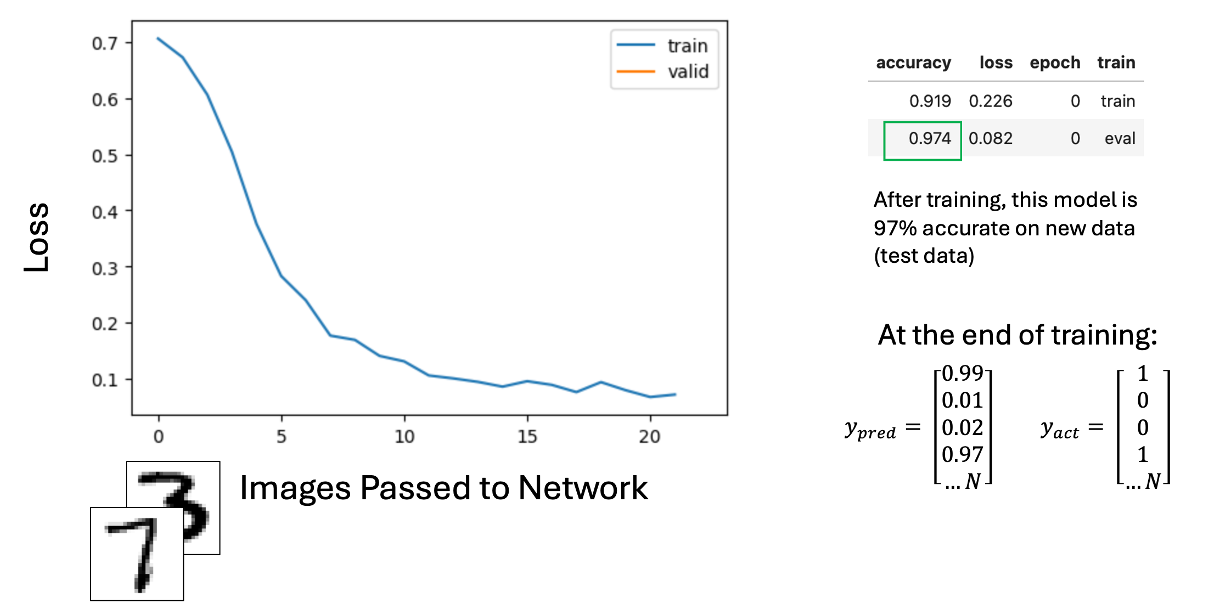

In [28]:
IMG("../AI_USU/Images/NN_summary.png")

That's 97% accuracy on classification of digits either 3 vs 7 with a neurnal network of 1 layer, using about 8000 parameters!

##### Pics

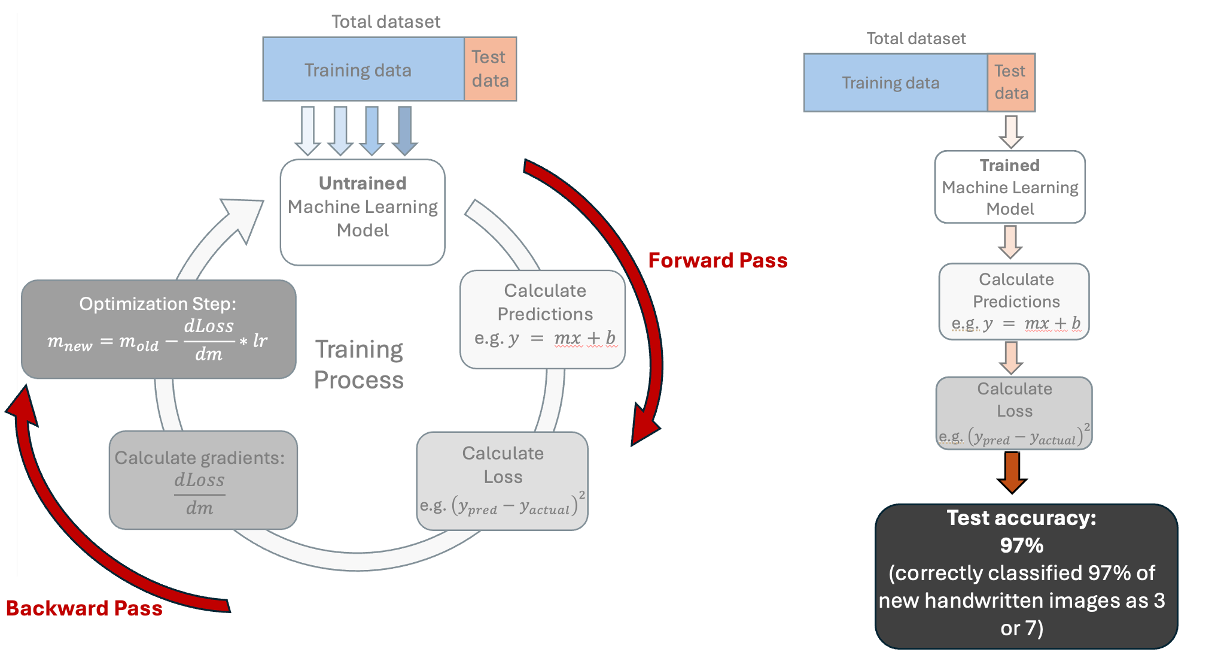

In [3]:
IMG("../AI_USU/Images/NN_conclusion.png")

And that's it!
- All complicated neural networks rely on these basic principles

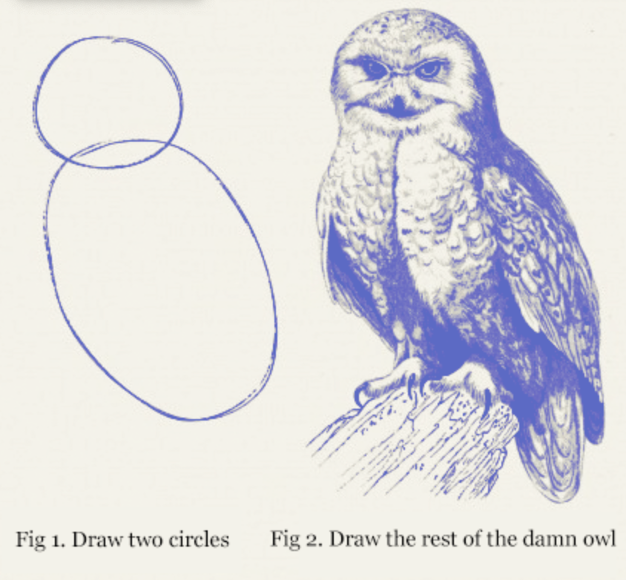

In [13]:
IMG("../AI_USU/Images/NN_owl.png")

Gross oversimplification of training a neural network is like drawing an own:
1. Draw two circles: analogous to setting up the basic building block of a neural network: choosing a model architecture, initializing parameters, etc
2. Draw the rest of the owl: let the neural network fill in all the intricate and complex details through numerous iterations of the training loop. The end result is a beautiful owl, ie an accurate neural network. So humans just do the easy task and let the neural network do all the millions of internal calculations.

## Multilayer Neural Networks (aka Deep Neural Networks)
- Using only one hidden layer with 10 nodes is limited by the complexity of data it can model
- Our simple neural network only has 7861 parameters, for reference, GPT-4 has 1.76 TRILLION parameters!
- What if we have a slightly more complicated dataset?

### MNIST dataset: handwritten digits 0-9

##### Code

In [14]:
current_directory = Path.cwd()
path_data = current_directory / '..' / 'nbs' / 'data'
path_gz = path_data / 'mnist.pkl.gz'
path_gz = path_gz.resolve()
print(path_gz)
with gzip.open(path_gz, 'rb') as f: ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
x_train, y_train, x_valid, y_valid = map(tensor, [x_train, y_train, x_valid, y_valid])

/notebooks/nbs/data/mnist.pkl.gz


In [15]:
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

(torch.Size([50000, 784]),
 torch.Size([50000]),
 torch.Size([10000, 784]),
 torch.Size([10000]))

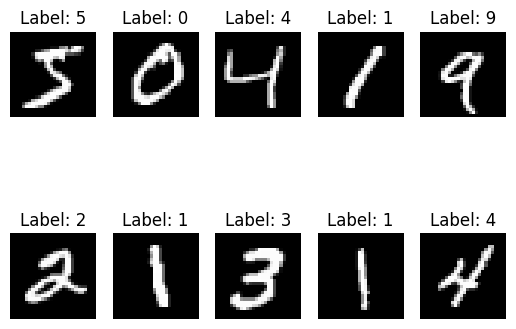

In [16]:
for i in range(10):
    plt.subplot(2, 5, i+1) 
    plt.imshow(x_train[i].reshape(28, 28), cmap='gray')  
    plt.title(f'Label: {y_train[i]}') 
    plt.axis('off')
plt.show() 

To predict 10 separate hand-written digits, lets train a wider and deeper model:

##### Pics

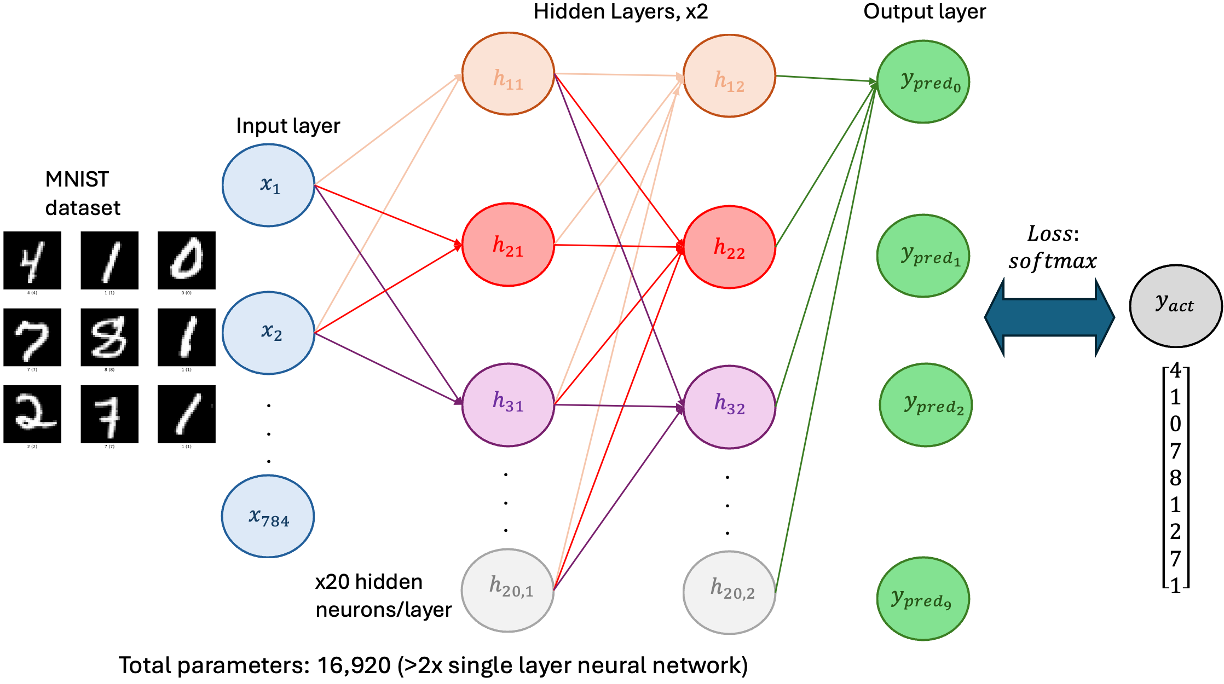

In [16]:
IMG("../AI_USU/Images/NN_deep.png")

##### Code

In [31]:
n,m = x_train.shape[0], x_train.shape[1]
c = y_train.max()+1
nh = 20
bs = 256

In [32]:
model = nn.Sequential(
    nn.Linear(m,nh),
    nn.ReLU(),
    nn.Linear(nh,nh),
    nn.ReLU(),
    nn.Linear(nh,c))

In [33]:
train_ds, valid_ds = Dataset(x_train,y_train), Dataset(x_valid,y_valid)
train_dl,valid_dl = get_dls(train_ds, valid_ds, bs)
dls = miniai_DataLoaders(train_dl,valid_dl)

In [34]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [DeviceCB(), metrics, ProgressCB(plot=True)]
learn = TrainLearner(model, dls, F.cross_entropy, lr=0.4, cbs=cbs, opt_func=optim.SGD)

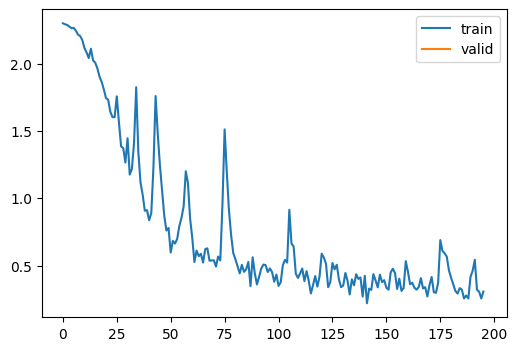

In [22]:
learn.fit(1)

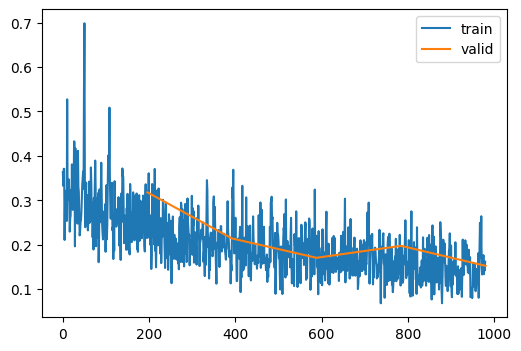

In [23]:
learn.fit(5)

##### Sidebar1: What actually going on with each parameters through every iteration:

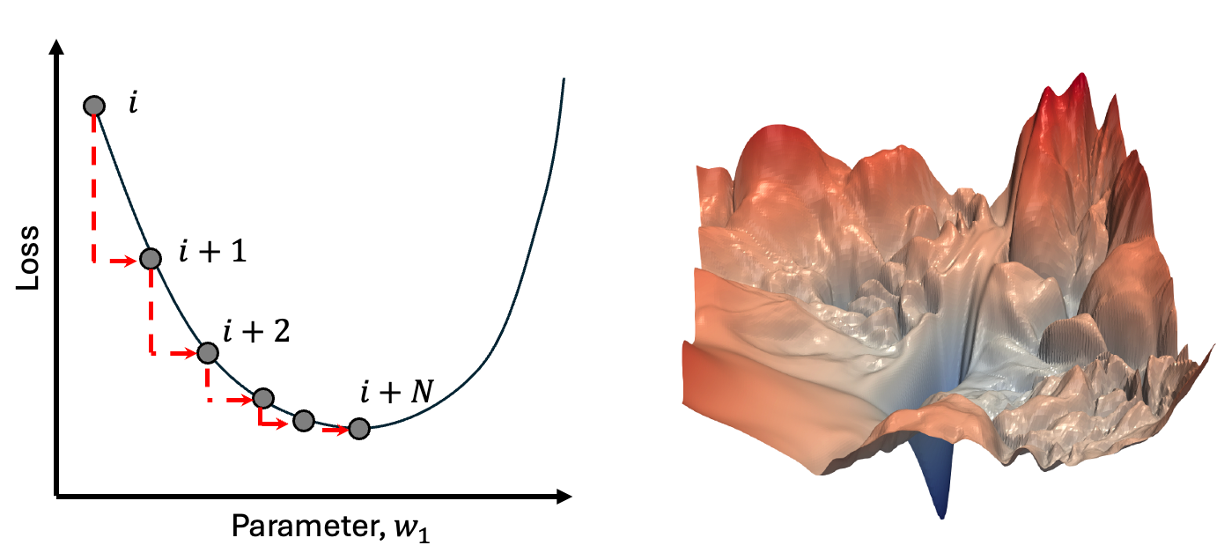

In [5]:
IMG("../AI_USU/Images/NN_loss_landscape.png")

##### Sidebar2: Over vs underfitting

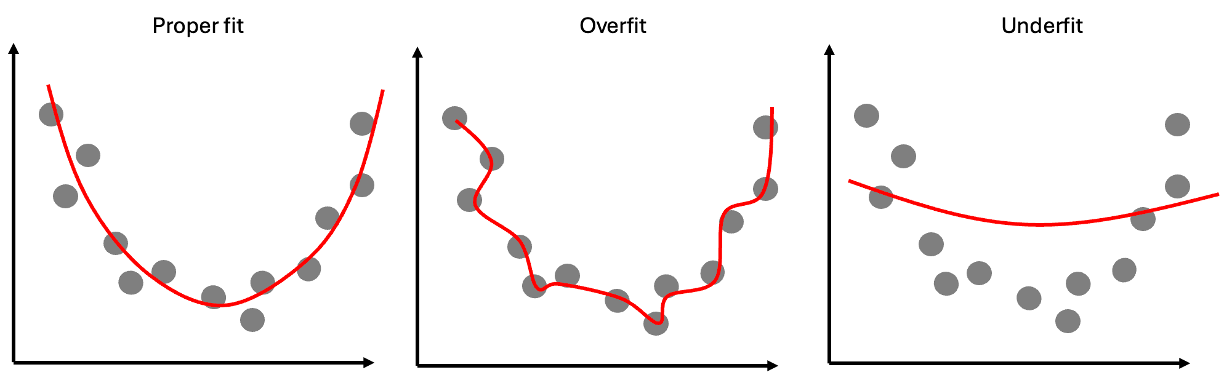

In [6]:
IMG("../AI_USU/Images/NN_over_under_fit.png")

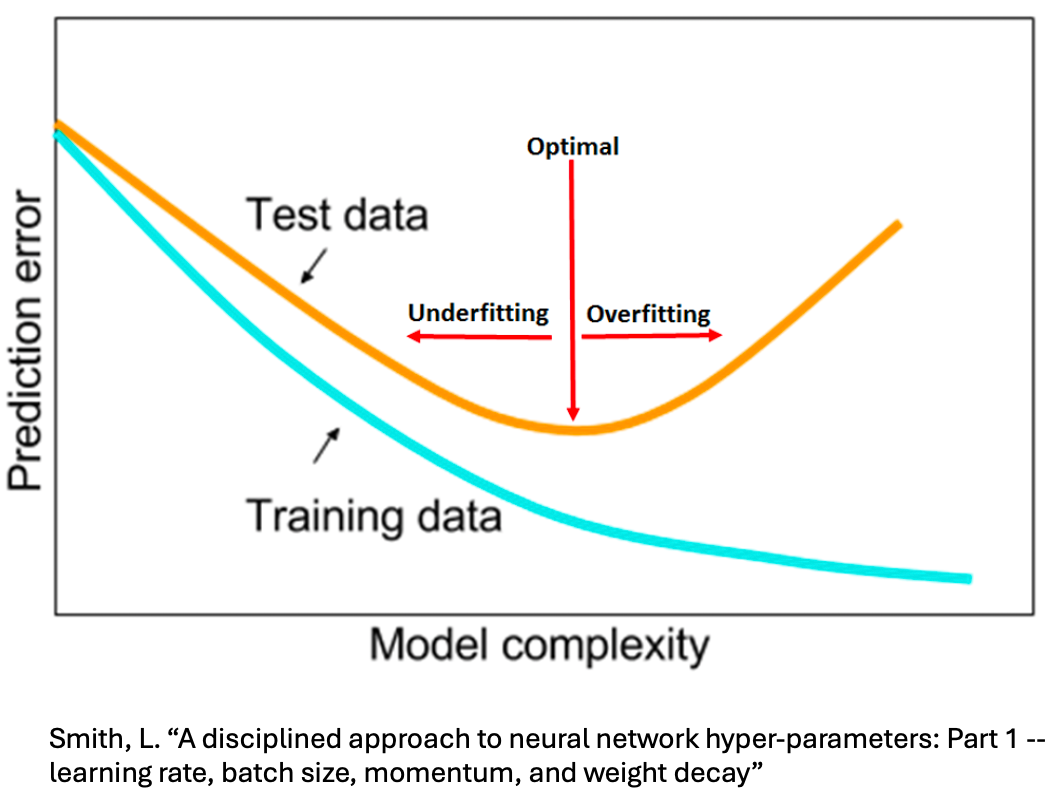

In [7]:
IMG("../AI_USU/Images/NN_Fitting.png")

End sidebar

## Convolutional Neural Networks
- We achieve a ~95% accuracy using a linear deep neural network with 16,920 parameters
- Is there a way to achieve better accuracy while using less parameters?
- Linear neural networks treat nearby pixels as if they're independent of each other. In realy, we know nearby pixels are related to each other (eg if a pixel = 255, good chance nearby ones are > 0). Can we use spatial relationships in our data to reduce the number of parameters? 
- Example: The facial recognition technology on your phone uses convolutions to classify images (labels a face with a name).

### What is a convolution:
- Just a mathematical operation: multiply and adds numbers together. Put these operations on a GPU and it goes really fast.
- Let's create a "filter" to look for visually distinct parts of an image

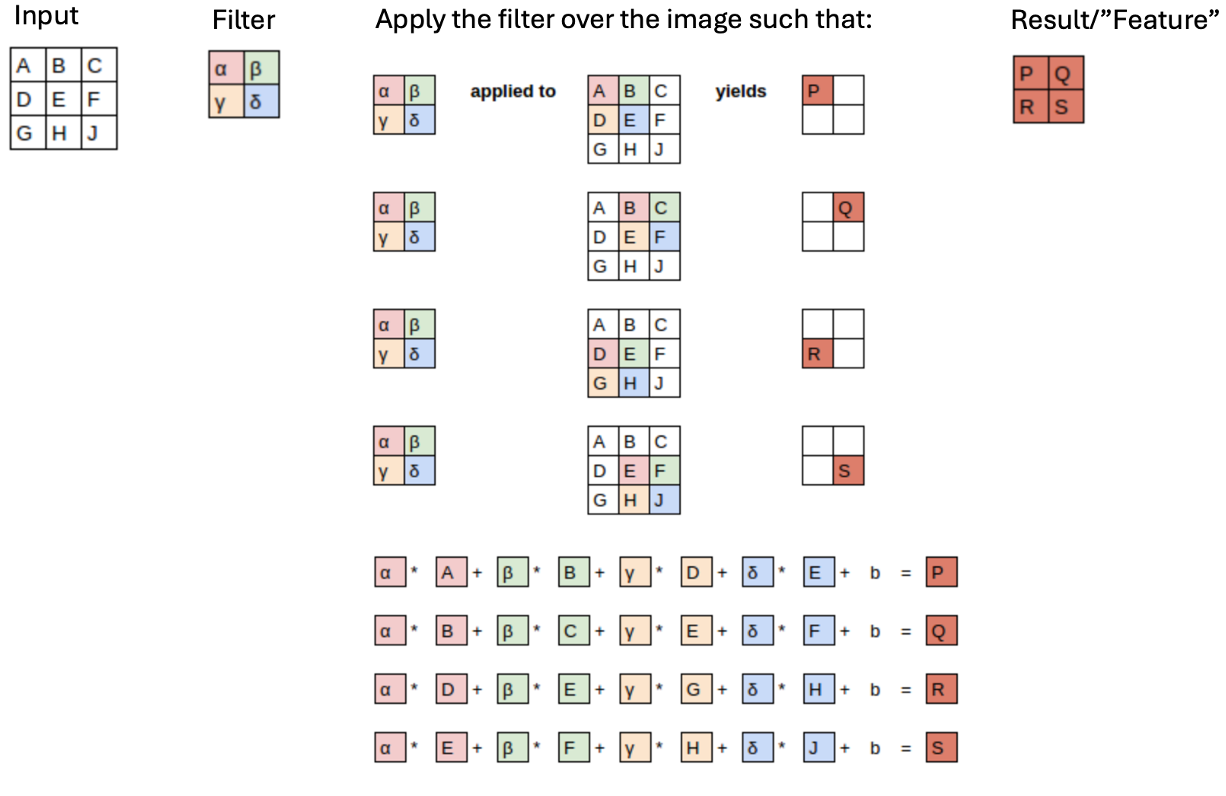

In [49]:
IMG("../AI_USU/Images/CNN_overview.png")

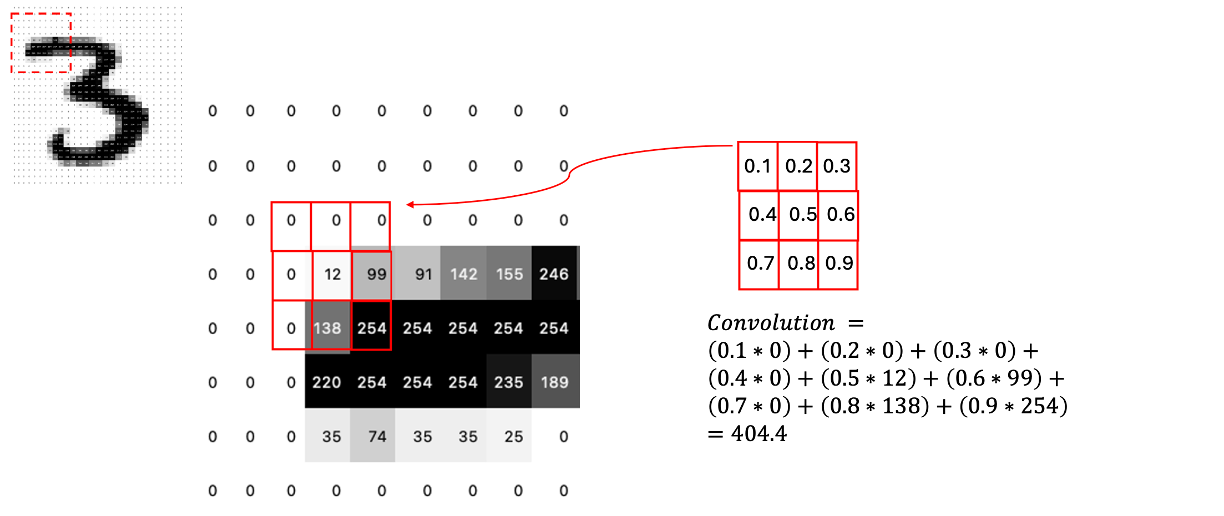

In [24]:
IMG("../AI_USU/Images/CNN_ex_calc_new.png")

- 3 is characterized by a series of horizontal, diagonal, and vertial edges
- Create a few filters to extract different features of the handwritten 3:

In [25]:
top_edge = tensor([[-1,-1,-1],
                   [ 0, 0, 0],
                   [ 1, 1, 1]]).float()

left_edge = tensor([[-1,0,1],
                    [-1,0,1],
                    [-1,0,1]]).float()

diag1_edge = tensor([[ 0,-1, 1],
                     [-1, 1, 0],
                     [ 1, 0, 0]]).float()

edges = torch.stack([top_edge, left_edge, diag1_edge])

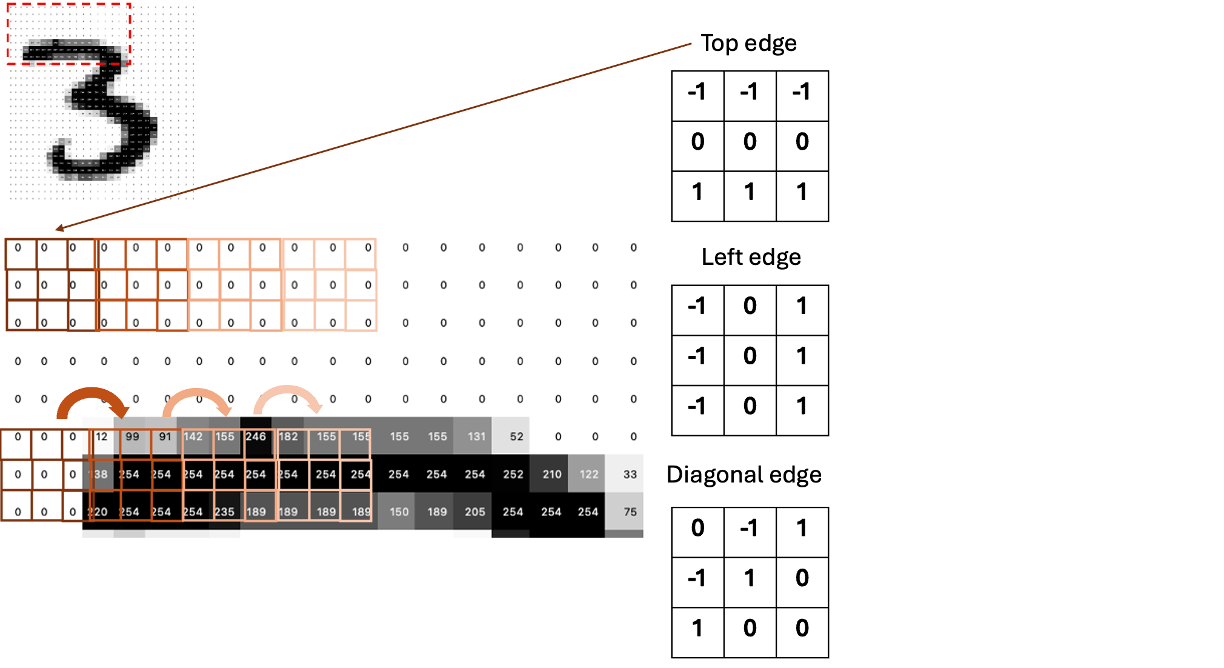

In [70]:
IMG("../AI_USU/Images/CNN_filters.png")

In [26]:
def apply_kernel(im, row, col, kernel): return (im[row-1:row+2,col-1:col+2] * kernel).sum()

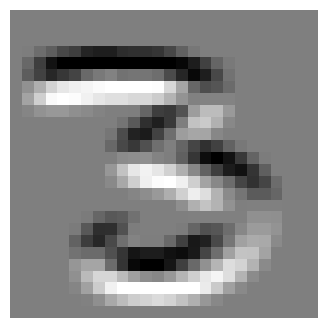

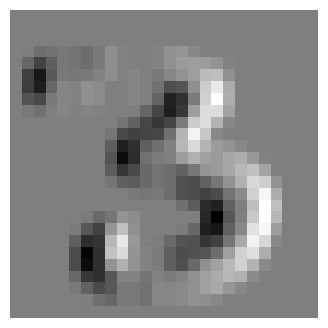

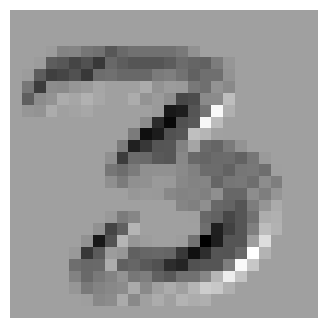

In [37]:
for kernel in edges:
    new_im = tensor([[apply_kernel(im3_t, i, j, kernel) for j in range(1,27)] for i in range(1,27)])
    show_image(new_im, figsize=(4,4))

### Create a neural net applying knowledge of convolutions:

In [38]:
x_train_cnn, y_train_cnn, x_valid_cnn, y_valid_cnn = x_train.view(-1,1,28,28) , y_train, x_valid.view(-1,1,28,28) , y_valid

In [39]:
x_train_cnn.shape, y_train_cnn.shape, x_valid_cnn.shape, y_valid_cnn.shape

(torch.Size([50000, 1, 28, 28]),
 torch.Size([50000]),
 torch.Size([10000, 1, 28, 28]),
 torch.Size([10000]))

In [40]:
train_ds_cnn, valid_ds_cnn = Dataset(x_train_cnn,y_train_cnn), Dataset(x_valid_cnn,y_valid_cnn)
train_dl_cnn,valid_dl_cnn = get_dls(train_ds_cnn, valid_ds_cnn, bs)
dls_cnn = miniai_DataLoaders(train_dl_cnn,valid_dl_cnn)

In [41]:
simple_cnn = nn.Sequential(
    conv(1,4),              # 14x14
    conv(4,8),              # 7x7
    conv(8,16),             # 4x4
    conv(16,32),            # 2x2
    conv(32,10, act=False), # 1x1
    nn.Flatten()
).to(def_device)

In [42]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [DeviceCB(), metrics, ProgressCB(plot=True)]
learn_cnn = TrainLearner(simple_cnn, dls_cnn, F.cross_entropy, lr=0.4, cbs=cbs, opt_func=optim.SGD)

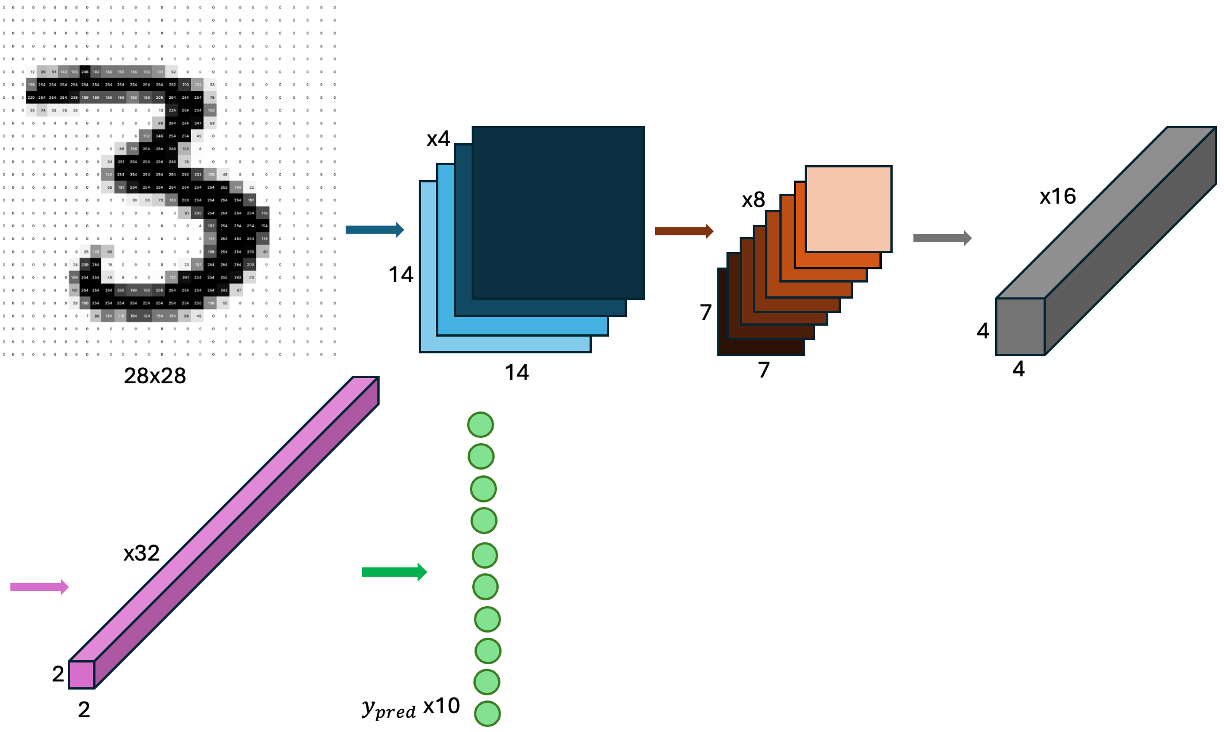

In [43]:
IMG("../AI_USU/Images/CNN_Simple.png")

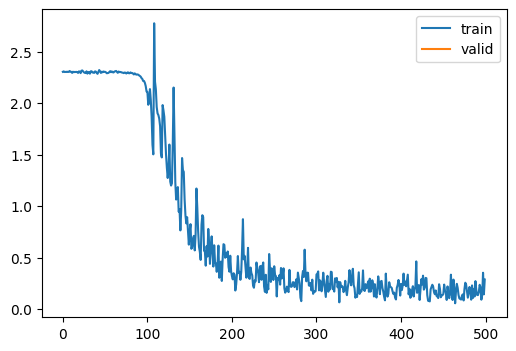

In [28]:
learn_cnn.fit(1)

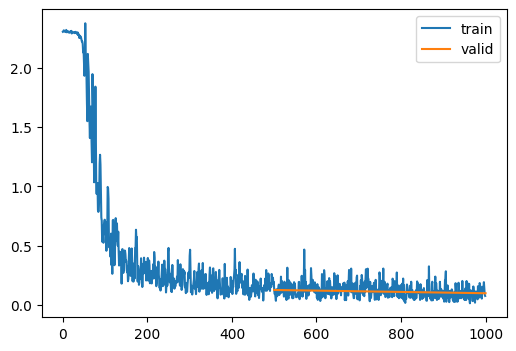

In [35]:
learn_cnn.fit(2)

Just achieve 97% accuracy after 2 epochs compared to 94% with a linear model and we only used 9034 parameters (9k compared to 16K, 56% of the parameters)!

##### Pics

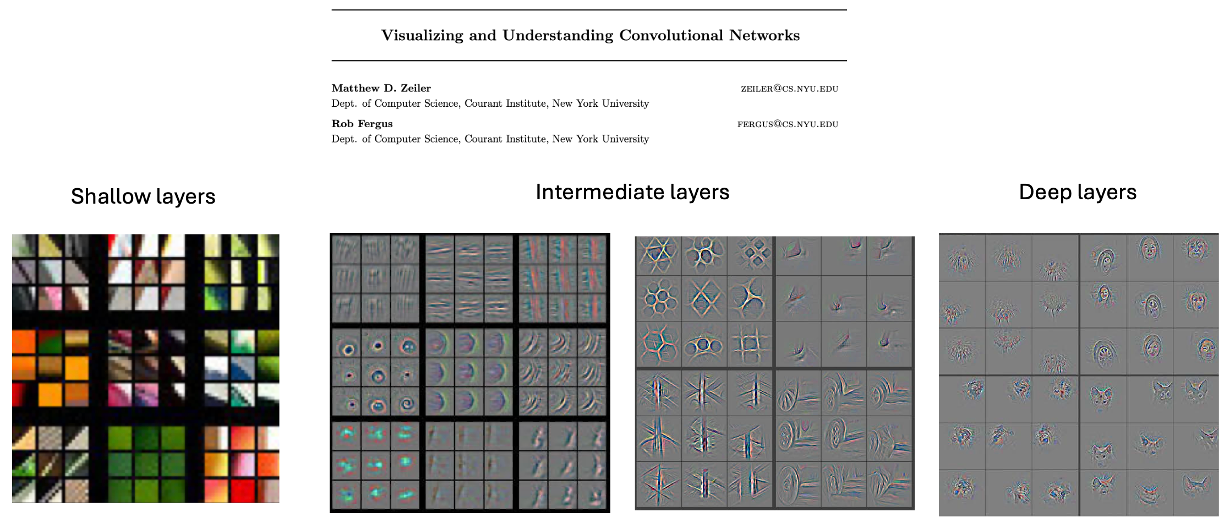

In [37]:
IMG("../AI_USU/CNN_visualizing.png")

# Natural Language Processing (NLP)
- Computers only know 1's and 0's, they dont know words. 
- Need to convert words/letters to numbers
- Pass the numbers through a neural network to predict the next word in a sentence
- Form of self-supervised learning: subset of supervised ML where the data provides its own supervision, allowing the model to generate labels automatically from the input itself.
- Relatively newer field compared to computer vision. NLP models only became useful about 5 years. Computer vision models have been effecive for longer.
- Basic language models are only trained to predict the next word in a sentence (form of self-supervised learning: training a model using labels embedded in the independent variable). This isn't exactly true with Large Language Models but the basic principles still hold true.

#### Imports

In [14]:
!pip install nltk
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from collections import Counter
from fastai.text.all import *
path_nlp = untar_data(URLs.HUMAN_NUMBERS)
from fastai.learner import Learner as Learner_fastai
from fastai.learner import Module as Module_fastai

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Basic steps

### Step 1: Tokenization
- Breaking down a sequence of text into smaller units, called tokens. These tokens can be as small as individual characters or as large as entire words or phrases.
- Word tokenizaiton vs subword
- Tokens are basically the vocabulary the used by the NLP algorithm

In [46]:
print(word_tokenize("I cannot have a $1.00."))

['I', 'can', 'not', 'have', 'a', '$', '1.00', '.']


In [47]:
text = "Diffuse bilateral interstitial and alveolar opacifications, more prominent in the lower lobes, consistent with multifocal pneumonia."
tokens = word_tokenize(text)
print(tokens)

['Diffuse', 'bilateral', 'interstitial', 'and', 'alveolar', 'opacifications', ',', 'more', 'prominent', 'in', 'the', 'lower', 'lobes', ',', 'consistent', 'with', 'multifocal', 'pneumonia', '.']


### Step 2: Create an embedding matrix:
- Assign a vector (unique set of numbers) for every token. Lets you encode semantic meaning in each token.
- Practical example of the word "heart"
    - Can have many different meanings: heart->love, heart->grit, heart->medical [anatomy, physiology, pathology: heart failure (edema, SOB)].
- Assigning a long list of numbers to each token is a way that a computer can encapsulate meaning in a word and relationships to other words in a very high dimensional space
    - Words with similar embeddings likely have similar meaning: ex2: “heart” might be represented by a set of numbers like [0.1, -0.3, 0.5, ...], and the word “chest” might be [0.2, -0.4, 0.6, ...], but "car" might be [5.4, 7.2, 9.6, ...]
- Embedding vectors are pre-trained
     - GPT3 uses about 12,000 embeddings for each token. GPT4 uses even more!

In [50]:
vocab = Counter(tokens)
vocab = {word: idx for idx, (word, _) in enumerate(vocab.items())}
indices = [vocab[token] for token in tokens]

In [54]:
glove_embeddings = {}
for k,_ in vocab.items():
    glove_embeddings[k] = np.random.randn(10)
    
for i, (k, v) in enumerate(glove_embeddings.items()):
    formatted_embedding = ', '.join(f'{x:6.2f}' for x in v)  
    print(f'Token: {k: <15},  Embedding: [{formatted_embedding}]')

Token: Diffuse        ,  Embedding: [  0.84,  -1.13,   0.53,   1.44,  -2.47,  -0.80,   0.58,  -0.20,   0.37,  -0.60]
Token: bilateral      ,  Embedding: [  0.09,  -0.16,   1.17,   0.25,   0.34,  -0.41,  -0.49,  -0.43,   0.39,  -0.42]
Token: interstitial   ,  Embedding: [  0.29,   2.08,   0.87,  -0.33,   1.20,  -0.41,  -2.04,  -1.01,  -1.87,  -0.35]
Token: and            ,  Embedding: [  0.02,   1.68,   0.33,  -0.22,   0.83,  -2.21,   0.24,   0.77,  -1.48,   1.14]
Token: alveolar       ,  Embedding: [  0.34,  -0.42,   0.63,   2.27,   0.18,   0.25,  -0.46,  -0.85,   0.83,  -0.86]
Token: opacifications ,  Embedding: [  0.07,  -0.48,   0.48,   0.33,   1.04,  -0.51,  -0.27,  -0.98,  -0.44,   0.38]
Token: ,              ,  Embedding: [  0.76,  -0.92,   0.87,   1.36,   0.41,   1.88,  -0.77,  -1.24,  -1.78,   1.50]
Token: more           ,  Embedding: [  0.65,  -0.06,   0.28,  -1.13,   2.45,   0.13,   0.11,   0.73,   0.48,   0.22]
Token: prominent      ,  Embedding: [ -0.79,   0.47,   1.88,   1

### Step 3: Pass the embedding matrix as the input of a neural network to predict the next word
- let's talk about a relatively simple language model that's in your learning objects: a Recurrent Neural Network (RNN)

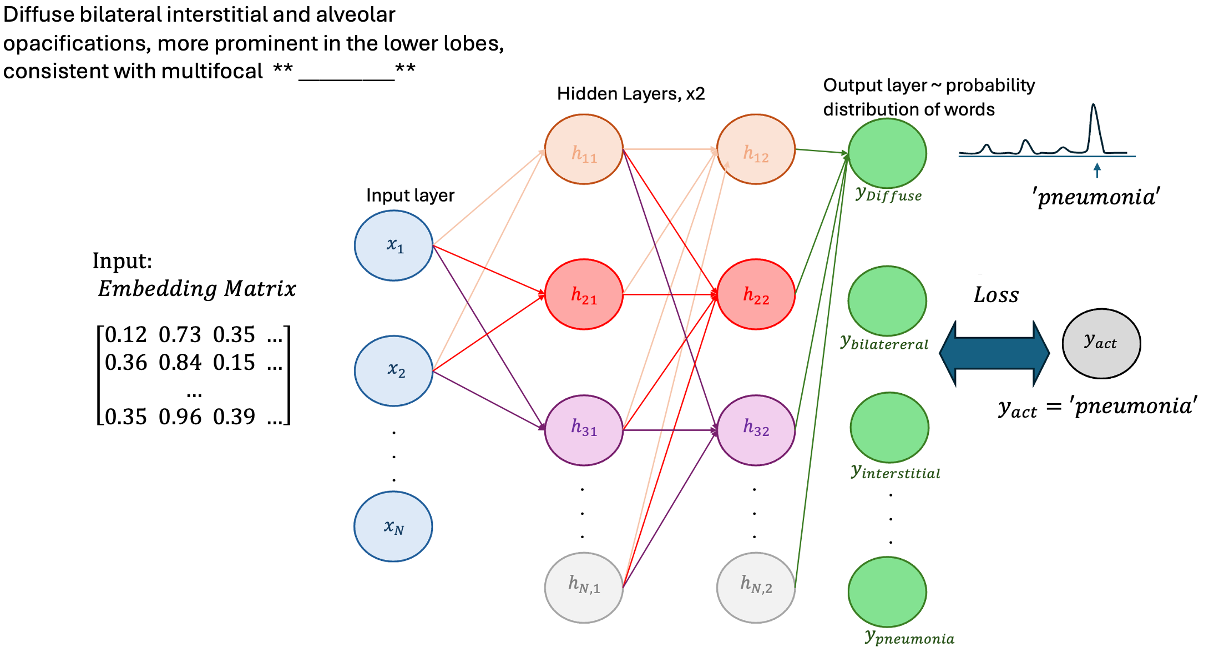

In [55]:
IMG("../AI_USU/Images/NLP_overview_new.png")

This is essentially a classification problem. Instead of predicting an label given an image, we predict the next word (token) give a sequence of previous words. Our neural network tells us the probability that each word in our vocab will be the "correct" next word in the sentence.

## Recurrent Neural Networks
- Literally guesses the next word in a sentence/sequence
- Good for small sentences but performance quickly deteriorates with longer sequences
- Aren't used often today but I assume they're in your learning objective because they from the basis of LLMs like transformers (eg GPT-4)

### Intro

#### Pics

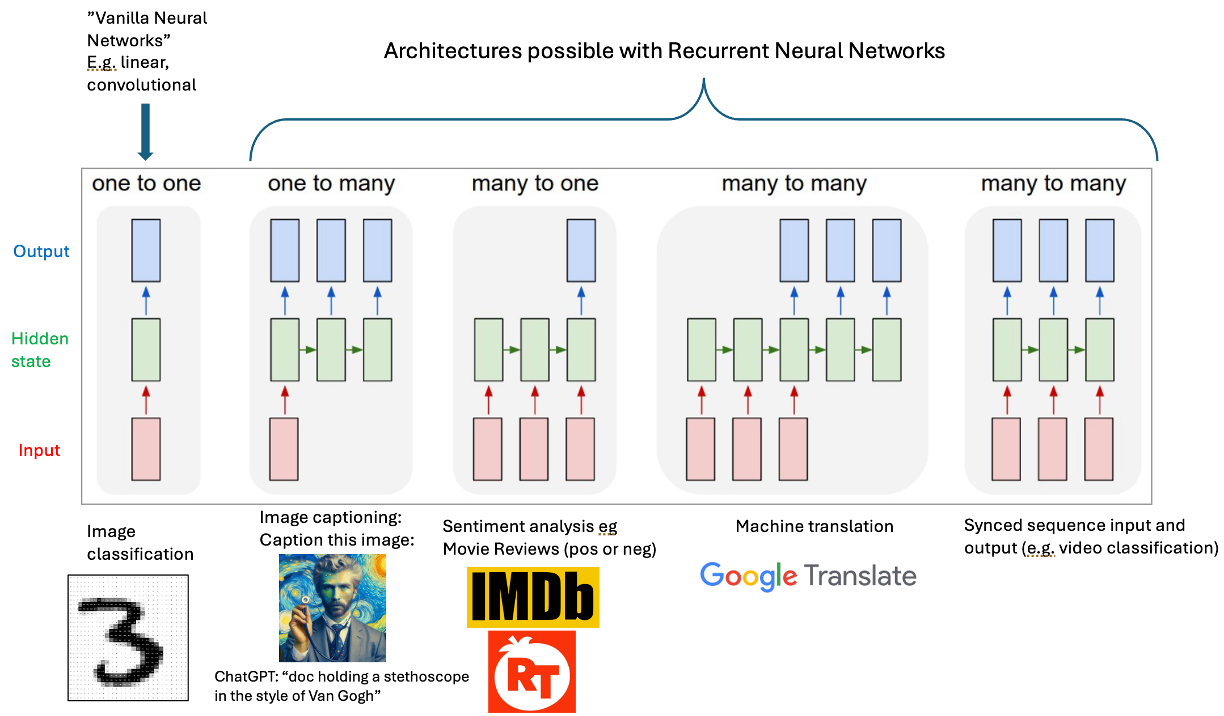

In [65]:
IMG("../AI_USU/Images/RNN_overview_new.png") #http://karpathy.github.io/2015/05/21/rnn-effectiveness/

Notice that in every case there are no pre-specified constraints on the length of sequences because the recurrent transformation (green) is fixed and can be applied as many times as we like.

#### Code
- Predict the next word in an ordered list from 1 to 1,000

In [66]:
lines = L()
with open(path_nlp/'train.txt') as f: lines +=L(*f.readlines())
with open(path_nlp/'valid.txt') as f: lines +=L(*f.readlines())
text = ' . '.join([l.strip() for l in lines])
text[:97], text[10005:10100], text[300023:300110]

('one . two . three . four . five . six . seven . eight . nine . ten . eleven . twelve . thirteen .',
 ' four hundred fifty four . four hundred fifty five . four hundred fifty six . four hundred fift',
 'eight thousand three hundred twenty three . eight thousand three hundred twenty four . ')

In [60]:
tokens = text.split(' ') 
#tokens[:10], tokens[-10:len(tokens)]

Tokens, ie our models vocabulary:

In [61]:
vocab = L(*tokens).unique()
for v in vocab:
    print(v)
len(vocab)

one
.
two
three
four
five
six
seven
eight
nine
ten
eleven
twelve
thirteen
fourteen
fifteen
sixteen
seventeen
eighteen
nineteen
twenty
thirty
forty
fifty
sixty
seventy
eighty
ninety
hundred
thousand


30

In [62]:
word2idx = {w:i for i,w, in enumerate(vocab)}
nums = L(word2idx[i] for i in tokens)
#nums[:10], nums[-10:-1], len(nums)

### Task 1: Predict the next word/element given the previous 4 words.
- independent variables: chunks of 4 words: [one ,  . ,  two ,  . ]
- dependent variable: 5th word: 'three'

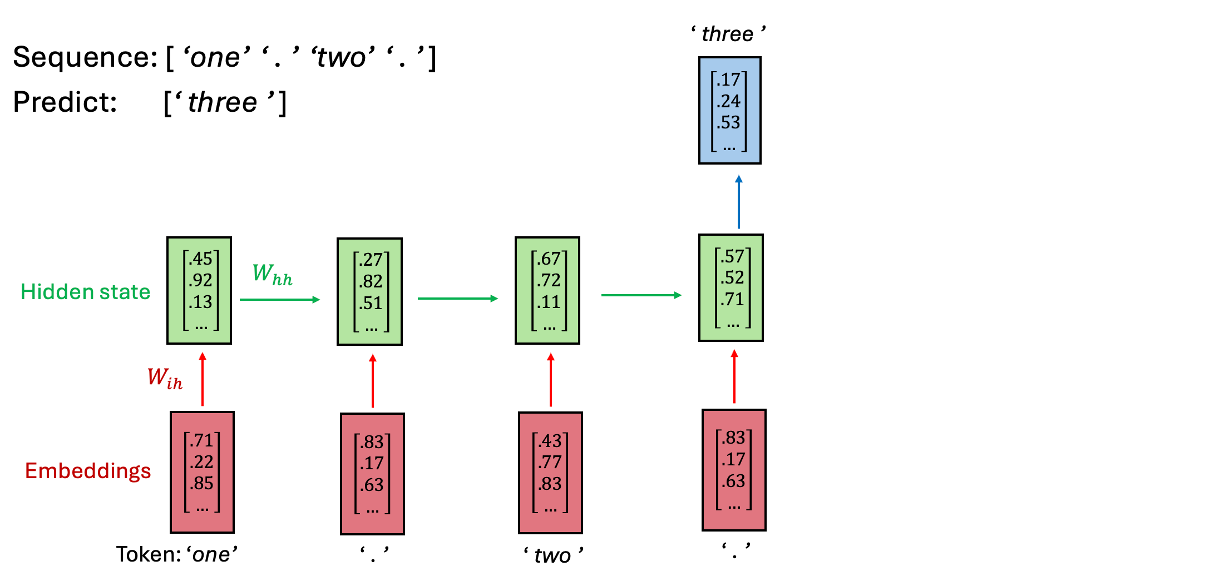

In [57]:
IMG("../AI_USU/Images/RNN_seq1.png")

- Let's look at our dateset broken down into independent (first 4 elements) and dependent variables (fifth element):

In [68]:
L((tokens[i:i+4],tokens[i+4]) for i in range(0,len(tokens)-5,4))[:3]

(#3) [(['one', '.', 'two', '.'], 'three'),(['three', '.', 'four', '.'], 'five'),(['five', '.', 'six', '.'], 'seven')]

In [12]:
bs = 64
cut = int(len(seqs)*0.8)

In [15]:
class RNNModel(Module_fastai):
    def __init__(self, vocab_sz, n_hidden):
        self.i_h = nn.Embedding(vocab_sz, n_hidden)
        self.h_h = nn.Linear(n_hidden, n_hidden)
        self.h_o = nn.Linear(n_hidden, vocab_sz)
        self.h = torch.zeros(1).to(torch.device("cuda"))
        
    def forward(self, x):
        for i in range(4):
            self.h = self.h + self.i_h(x[:,i])
            self.h = F.relu(self.h_h(self.h))
        out = self.h_o(self.h)
        self.h = self.h.detach()
        return out
    
    def reset(self): self.h = 0

In [16]:
def group_chunks(ds,bs):
    m = len(ds)//bs #328, 21031, 64
    new_ds = L()
    for i in range(m): 
        new_ds+=L(ds[i+m*j] for j in range(bs))
    return new_ds

In [18]:
dls = DataLoaders.from_dsets(
    group_chunks(seqs[:cut],bs),
    group_chunks(seqs[cut:],bs),
    bs = bs, drop_last = True, shuffle = False).cuda()

In [19]:
model_RNN1 = RNNModel(len(vocab),64).to(def_device)

In [20]:
learn_nlp1 = Learner_fastai(dls, model_RNN1, loss_func=F.cross_entropy, metrics=accuracy, cbs=ModelResetter)

In [21]:
learn_nlp1.fit_one_cycle(5, 3e-3)

- For 5 epochs, accuracy 46%, run time: 24 sec  (65 sec on CPU)
- Saw evidence of overfitting at the last epoch
- Total model parameters: 8030

### Task 2: Same as Task 1, except output the next word for every word passed in
- Independent variable is still a sequence: eg [ one , . , two , . ]
- Dependent variable is now that sequence shifted over one character to the right: [ . , two ,  . , three ]

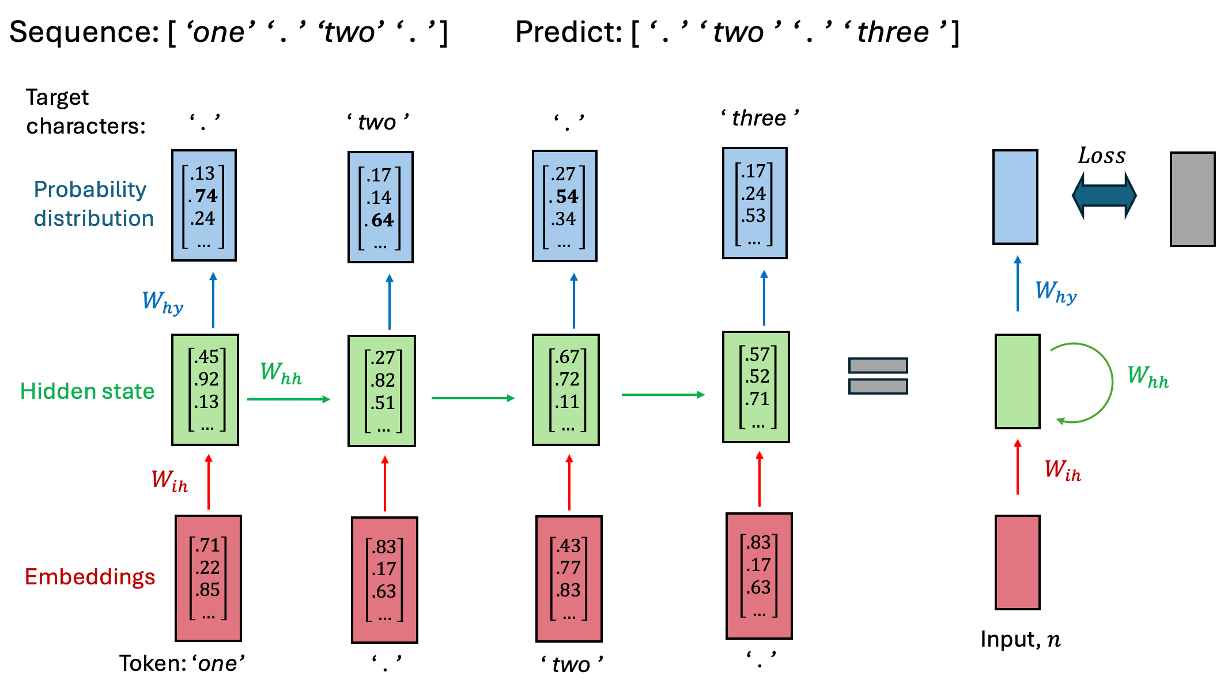

In [58]:
IMG("../AI_USU/Images/RNN_seq2.png")

In [22]:
sl = 4 
seqs = L((tensor(nums[i:i+sl]),tensor(nums[i+1:i+sl+1])) for i in range(0,len(nums)-sl-1,sl)) #3943 indiv sequences in total dataset
cut = int(len(seqs)*0.8)
dls = DataLoaders.from_dsets(
    group_chunks(seqs[:cut],bs),
    group_chunks(seqs[cut:],bs),
    bs = bs, drop_last = True, shuffle = False).cuda()

In [23]:
[L(vocab[o] for o in s) for s in seqs[0]] #new dependent variable

[(#4) ['one','.','two','.'], (#4) ['.','two','.','three']]

In [47]:
class RNNModel2(Module_fastai):
    def __init__(self, vocab_sz, n_hidden):
        self.i_h = nn.Embedding(vocab_sz, n_hidden)
        self.h_h = nn.Linear(n_hidden, n_hidden)
        self.h_o = nn.Linear(n_hidden, vocab_sz)
        self.h = torch.zeros(1).to(torch.device("cuda"))
        
    def forward(self, x):
        outs = []
        for i in range(sl):
            self.h = self.h + self.i_h(x[:,i])
            self.h = F.relu(self.h_h(self.h))
            outs.append(self.h_o(self.h))
        self.h = self.h.detach()
        return torch.stack(outs,dim=1)  #outs = [bs,sl,vocab_sz], prob distro for each bs and each element in sl
    
    def reset(self): self.h = 0

In [48]:
def loss_func(inp,targ):
    return F.cross_entropy(inp.view(-1,len(vocab)),targ.view(-1)) #comparing [1024,30] to [1024]

In [49]:
model_RNN2 = RNNModel2(len(vocab),64).to(def_device)

In [50]:
learn_nlp2 = Learner_fastai(dls, model_RNN2, loss_func=loss_func, metrics=accuracy, cbs=ModelResetter)
learn_nlp2.fit_one_cycle(5,3e-3)

- Accuracy: 50%
- Run time: 25 sec, theoretically more calculations (more weight updates, gradient calculations, etc) but overall affect is neglegible 
- Evidence of overfitting at 5th epoch
- However: approach is often more useful and flexible.
    - Want to generate one word after the other (like ChatGPT), not just every 5th word.
- Total model parameters: 8030

### Task 3: Same as Task 2, but increase the sequence length to 16.
- insight: when training neural networks, start with a simple model, test it, then continue to refine it by gradually increasing model complexity in each successive iteration.
- Independent variable: [one, . , two , . , three , . , four , . , five , . , six , . , seven , . , eight , . ]
- Dependent variable: [ . , two , . , three , . , four , . , five , . , six , . , seven , . , eight , . , nine]

In [24]:
sl = 16 
seqs = L((tensor(nums[i:i+sl]),tensor(nums[i+1:i+sl+1])) for i in range(0,len(nums)-sl-1,sl)) 
cut = int(len(seqs)*0.8)
dls = DataLoaders.from_dsets(
    group_chunks(seqs[:cut],bs),
    group_chunks(seqs[cut:],bs),
    bs = bs, drop_last = True, shuffle = False).cuda()

In [25]:
[L(vocab[o] for o in s) for s in seqs[0]]

[(#16) ['one','.','two','.','three','.','four','.','five','.','six','.','seven','.','eight','.'],
 (#16) ['.','two','.','three','.','four','.','five','.','six','.','seven','.','eight','.','nine']]

In [54]:
learn_nlp3 = Learner_fastai(dls, model_RNN2, loss_func=loss_func, metrics=accuracy, cbs=ModelResetter)
learn_nlp3.fit_one_cycle(5,3e-3)

- About the same accuracy 60%
    - Intuitively would expect this to be more accurate than the short sequences because this model has a greater "memory" of the previous sequences. However, one of the limitations of RNNs is that their "memory" of past events is limited
- Faster run time: 16 sec
     - Faster batch processing (less sequences to handle)
     - Longer sequences often better optimized for parallel computing on the GPU
- Earlier evidence of overfitting
- Total model parameters: 8030

### Task 4: Build a deeper network: Stack RNNs on top of each other, otherwise same as Task 3

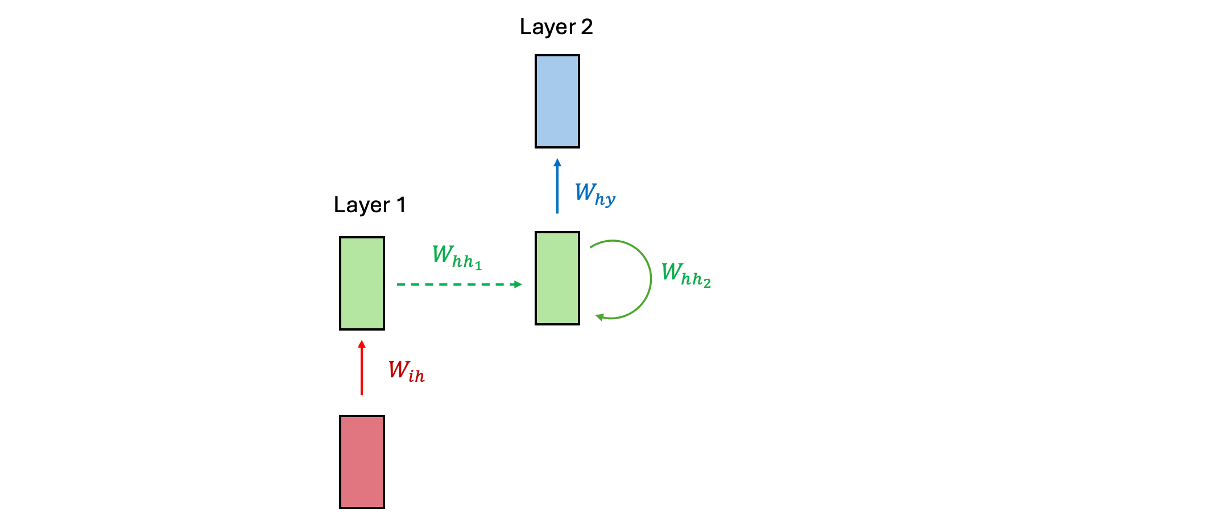

In [59]:
IMG("../AI_USU/Images/RNN_stacked.png")

In [57]:
class RNNModel3(Module_fastai):
    def __init__(self,vocab_sz, n_hidden, n_layers):
        self.h_i = nn.Embedding(vocab_sz, n_hidden)
        self.rnn = nn.RNN(n_hidden, n_hidden, n_layers, batch_first=True)
        self.h_o = nn.Linear(n_hidden, vocab_sz)
        self.h = torch.zeros(n_layers,bs,n_hidden).to(torch.device("cuda"))
    
    def forward(self,x):
        res,h = self.rnn(self.h_i(x), self.h)
        self.h = h.detach()
        return self.h_o(res)
    
    def reset(self): self.h.zero_()

In [58]:
model_RNN3 = RNNModel3(len(vocab),64,2).to(def_device)

In [59]:
learn_nlp4 = Learner_fastai(dls, model_RNN3, loss_func=loss_func, metrics=accuracy, cbs=ModelResetter)

In [60]:
learn_nlp4.fit_one_cycle(5,3e-3)

Meh
- Worse accuracy: 50%
- Total parameters: 20,510 (over double) but same run time (more parameters != slower run time)
- Deeper networks are not always better. Weights can grow to infinity or shrink to zero creating a very unstable model (vanishing/exploding gradient problem)
- RNNs form the basis of larger models (LSTM, transformers, etc) but by themselves are limited.

### Task 5: Modify an RNN to give it greater memory: LSTMs!
- Long Short-Term Memory model 
- Learn longer term dependencies of sequential data

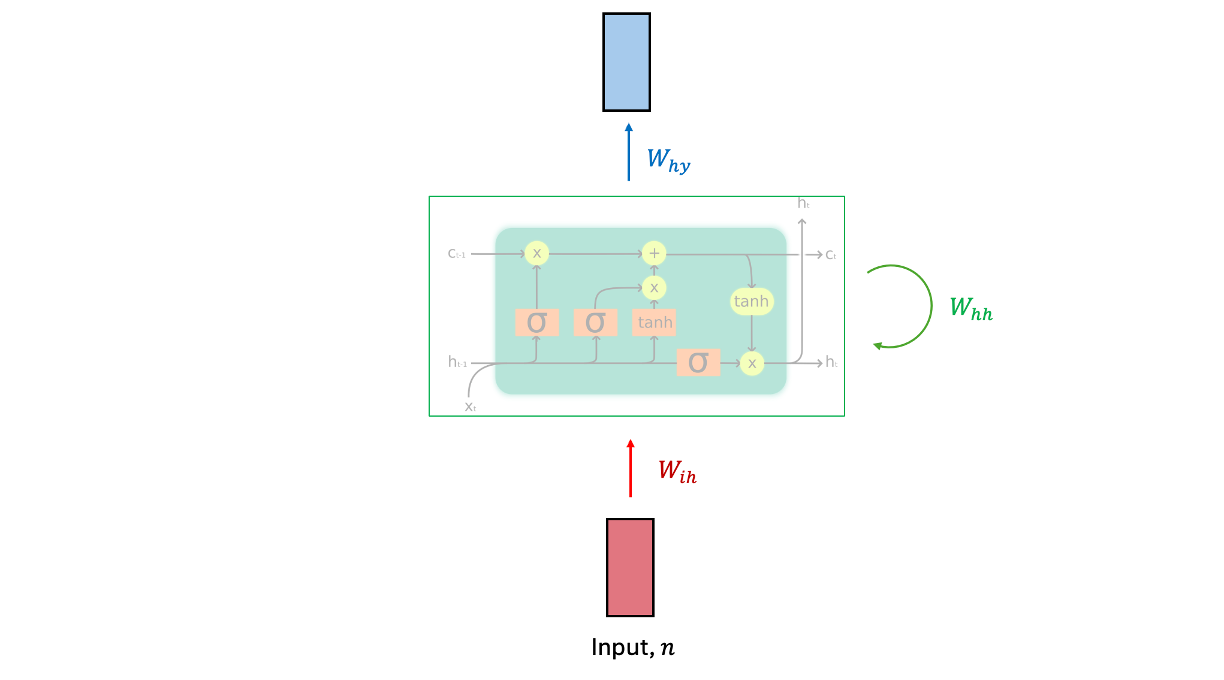

In [60]:
IMG("../AI_USU/Images/LSTM.png")

In [66]:
class LSTMModel(Module_fastai):
    def __init__(self, vocab_sz, n_hidden, n_layers):
        self.i_h = nn.Embedding(vocab_sz, n_hidden)
        self.rnn = nn.LSTM(n_hidden, n_hidden, n_layers, batch_first=True)
        self.h_o = nn.Linear(n_hidden, vocab_sz)
        self.h = [torch.zeros(n_layers, bs, n_hidden).to(torch.device("cuda")) for _ in range(2)]
        
    def forward(self, x):
        res,h = self.rnn(self.i_h(x), self.h)
        self.h = [h_.detach() for h_ in h]
        return self.h_o(res)
    
    def reset(self): 
        for h in self.h: h.zero_()

In [71]:
model_LSTM = LSTMModel(len(vocab),64,2).to(def_device)

In [72]:
learn_nlp5 = Learner_fastai(dls, model_LSTM, loss_func=loss_func, metrics=accuracy, cbs=ModelResetter)
learn_nlp5.fit_one_cycle(15,1e-2)

- Now we're getting somewhere!
- Accuracy: 74%, less evidence of overfitting, can train for more epochs. 
- Lets try some regulatizaiton technicques to reduce overfitting.

##### CPU example
- accidentally ran on a CPU, not GPU:

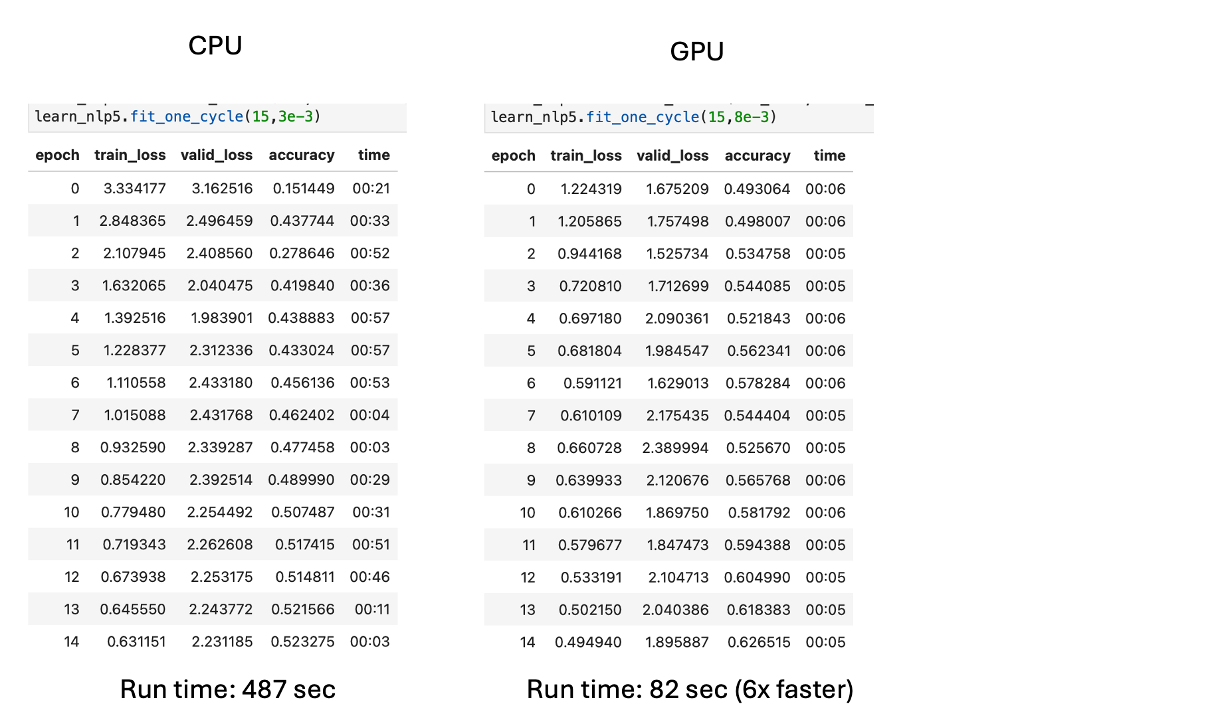

In [62]:
IMG("../AI_USU/Images/CPU_GPU.png")

### Task 6: LSTM with regularization
- regularization: variety of techniques to reduce overfitting

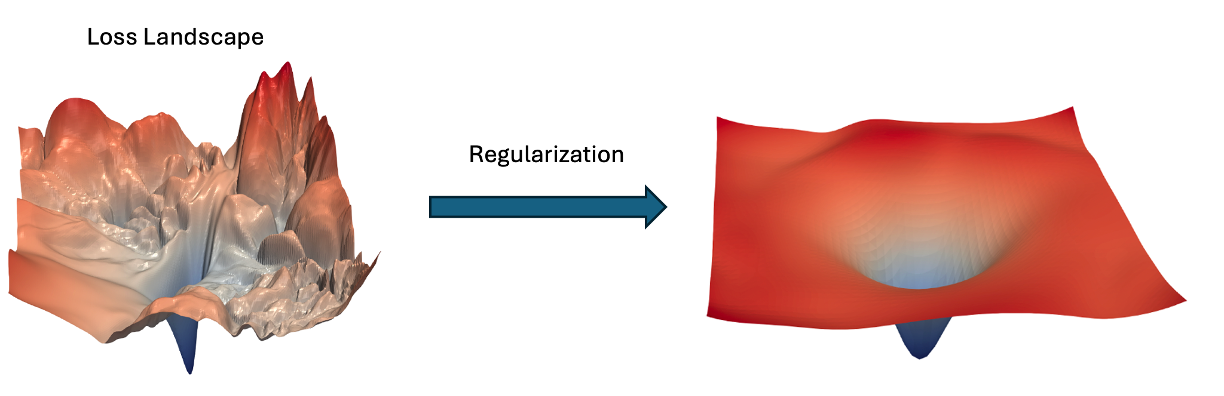

In [61]:
IMG("../AI_USU/Images/NN_regularization.png")

In [26]:
class Dropout(Module_fastai):
    def __init__(self, p): self.p = p
    def forward(self, x):
        if not self.training: return x
        mask = x.new(*x.shape).bernoulli_(1-self.p)
        return x*mask.div(1-self.p)

In [27]:
class LSTMModel_reg(Module_fastai):
    def __init__(self, vocab_sz, n_hidden, n_layers, p):
        self.i_h = nn.Embedding(vocab_sz, n_hidden)
        self.rnn = nn.LSTM(n_hidden, n_hidden, n_layers, batch_first=True)
        self.drop = nn.Dropout(p)
        self.h_o = nn.Linear(n_hidden, vocab_sz)
        self.h_o.weight = self.i_h.weight
        self.h = [torch.zeros(n_layers, bs, n_hidden).to(torch.device("cuda")) for _ in range(2)]
        
    def forward(self, x):
        raw,h = self.rnn(self.i_h(x), self.h)
        self.out = self.drop(raw)
        self.h = [h_.detach() for h_ in h]
        return self.h_o(self.out)
    
    def reset(self): 
        for h in self.h: h.zero_()

model_LSTM_reg = LSTMModel_reg(len(vocab),64,2,0.5).to(def_device)

learn_nlp6 = Learner_fastai(dls, model_LSTM_reg,
                loss_func=CrossEntropyLossFlat(), metrics=accuracy,
                cbs=ModelResetter)
learn_nlp6.fit_one_cycle(15,1e-2,wd=0.1)

- Alright! 90% accuracy with just applying two regularization techniques which is barely skratching the surface. 
- RNNs may not be the most accurate but they offer greater flexibility in outputs compared to other neural networks.
- RNNs also form the foundation of LLMs
- Don't get bogged down in the details in this section, just unddrstand the general process of sentence tokenization and embeddings that ultimately get passed in as the first layer to the neural network.
- Regularization is always a hot topics of interest in trailing neural networks and there no shortage of PhD disserations on the topic.
- If there's one thing I showed you taking you through these notebooks, it's that your DON'T need a PhD to do machine Learning!